In [1]:
import pandas as pd
from makeit.utilities.io import name_parser
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if mo
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

# clean trees to remove pathways with two or more low score reactions

In [2]:
with open("all_trees_cleaned.pkl",'r') as ATC:
    feasible_trees = pickle.load(ATC)

In [58]:
###clean trees
import pickle
import numpy as np
# with open('../pathways/all_trees.pickle','r') as TREE_FILE:
#     feasible_trees = pickle.load(TREE_FILE)

def get_stepwise_fsc_from_tree(fsc=[],tree={}):
    if 'is_reaction' in tree.keys():
        fsc.append(tree['forward_score'])
    for child in tree['children']:
        get_stepwise_fsc_from_tree(fsc,child)
    return(fsc)
def nonzero_mul(x):
    prod = 1
    for element in x:
        if element>=0.05:
            prod = prod*element
    return(prod)
trees_to_keep = []
cum_score_list = []
cum_score_with_penalty = []
contains_zero = []
for i, tree in enumerate(feasible_trees):
    if '.' in tree['tree']['smiles']:
        continue
    fsc = get_stepwise_fsc_from_tree(fsc=[],tree=tree['tree'])
    low_prob_count = sum([1 for sc in fsc if sc<0.05])
    if low_prob_count>1:
        continue
    elif low_prob_count==1:
        trees_to_keep.append(i)
        cum_score_list.append(nonzero_mul(fsc))
        cum_score_with_penalty.append(nonzero_mul(fsc)/20)
        contains_zero.append(True)
    else: 
        trees_to_keep.append(i)
        cum_score_list.append(np.prod(fsc))
        cum_score_with_penalty.append(np.prod(fsc))
        contains_zero.append(False)

feasible_trees = [feasible_trees[i] for i in trees_to_keep]
# 

In [59]:
print(len(feasible_trees))

193597


In [5]:
#####create the pandas dataset#####
###each row for a target, each column for a chemical####

def parse_context(context):
    context_combine_ion = context.replace('].[','<>')
    context_sep = context_combine_ion.split('.')
    parsed_context = [c.replace('<>','].[') for c in context_sep if c is not '']
    return parsed_context
def get_chemical_table_from_routes(routes, contexts):
    # all_chemicals = get_all_chemicals_in_all_routes(routes)
    # print(all_chemicals)
    # print(len(all_chemicals))
    all_routes_chemical_only = []
    all_routes_target = []
    all_routes_score = []
    for route in routes:
        route_target = route['chemicals'][0]['SMILES']
        route_chemical_only = [chemical['SMILES'] for chemical in route['chemicals'] if chemical['is_starting']]
        all_routes_chemical_only.append(route_chemical_only)
        all_routes_target.append(route_target)
        all_routes_score.append(route['score'])
    ohe = MultiLabelBinarizer()
    ohe_context = MultiLabelBinarizer()
    # ohe.fit(all_chemicals)
    # print('transformed')
    all_routes_chemical_onehot = ohe.fit_transform(all_routes_chemical_only)
    all_routes_context_onehot = ohe_context.fit_transform(contexts)
    chemical_smiles = list(ohe.classes_)
    context_smiles = list(ohe_context.classes_)
    return (all_routes_target, all_routes_chemical_onehot, chemical_smiles,all_routes_score, all_routes_context_onehot, context_smiles)

def get_chemicals_from_tree(tree, path = [],):
    path.append({'SMILES':tree['smiles'],
                 'is_starting': False})
    if not tree['children']:
        path[-1]['is_starting']=True
        pass
    else:
        for child in tree['children']:
            [get_chemicals_from_tree(child_chem, path) for child_chem in child['children']]
    return path

def get_context_from_tree(tree, path = [],):
    if not tree['children']:
        pass
    else:
        for child in tree['children']:
            context = child['context']
            [path.extend(parse_context(context[i])) for i in [1,2,3] if context[i]!='']
            [get_context_from_tree(child_chem, path) for child_chem in child['children']]
    return list(set(path))

all_routes = [{'chemicals':get_chemicals_from_tree(tree['tree'],path = []),'score':tree['score']} for tree in feasible_trees if tree['tree']['children']]
all_routes_contexts = [get_context_from_tree(tree['tree'],path = []) for tree in feasible_trees if tree['tree']['children']]
        
(all_routes_target,all_routes_chemical_onehot,chemical_smiles, all_routes_score, all_routes_context_onehot, context_smiles) = get_chemical_table_from_routes(all_routes, all_routes_contexts)
index_list_all_routes = range(len(all_routes))
context_smiles = ['context_'+smiles for smiles in context_smiles]
dataset = pd.DataFrame(all_routes_chemical_onehot, columns = chemical_smiles)
dataset_context = pd.DataFrame(all_routes_context_onehot, columns = context_smiles)
dataset['target'] = all_routes_target
dataset['index'] = index_list_all_routes
dataset['score'] = cum_score_with_penalty


In [61]:
# dataset['score'] = cum_score_with_penalty
# print(len(context_smiles))

In [7]:
dataset = dataset.assign(**dataset_context)

In [8]:
all_routes = []
all_routes_contexts = []
all_routes_target,all_routes_chemical_onehot,chemical_smiles, all_routes_score, all_routes_context_onehot, context_smiles = None,None,None,None,None,None
dataset_context = []

In [9]:
# dataset['score'] = cum_score_list
dataset.to_csv('cleaned_dataset_99_tar.csv')

In [10]:
####summarize the list of chemicals####

chemicals_list = list(dataset)
# print(chemicals_list)
target_list = list(dataset['target'])
# chemicals_list.remove('Unnamed: 0')
chemicals_list.remove('target')
chemicals_list.remove('score')
chemicals_list.remove('index')
# chemicals_list.remove('len_sc')

chemicals_list_no_context = [chemical for chemical in chemicals_list if 'context_' not in chemical]


chemicals_list_index = range(len(chemicals_list))
chemicals_dict = dict(zip(chemicals_list_index, chemicals_list))
chemicals_list_index_no_context = range(len(chemicals_list_no_context))
chemicals_dict_no_context = dict(zip(chemicals_list_index_no_context,chemicals_list_no_context))
print(len(chemicals_list),len(chemicals_list_no_context), len(set(target_list)))

(3910, 3340, 99)


# Calculate SCScores for chemicals

In [11]:
from makeit.prioritization.precursors.scscore import SCScorePrecursorPrioritizer
scscorer = SCScorePrecursorPrioritizer()
scscorer.load_model(model_tag='1024bool')

scscore_dict = {}
for key,value in chemicals_dict.iteritems():
    if 'context_' not in value:
        scscore_dict[key] = 1+scscorer.get_score_from_smiles(value, noprice=True)
    else:
        scscore_dict[key] = 1

In [12]:
print(np.average([sc for sc in scscore_dict.values() if sc!=1]))
print(np.average([scscorer.get_score_from_smiles(target, noprice = True) for target in list(set(target_list))]))

2.688792306616586
3.006803918802244


In [64]:
##########################optimization with context and evaluation
#define parameters
from tqdm import tqdm
parameters_eval = {}
parameters_score = {}
route_counter = 0
target_list_unique = []
for index,row in tqdm(dataset.iterrows()):

    parameters_score[route_counter] = -np.log(cum_score_list[route_counter])+contains_zero[route_counter]*(-np.log(0.05))
    if row['target'] not in target_list_unique: ## if a new target, reset route counting
        parameters_eval[row['target']]={}
        target_list_unique.append(row['target'])
    parameters_eval[row['target']][route_counter]={}
    parameters_eval[row['target']][route_counter]=dict(zip(chemicals_list_index,row[chemicals_list]))
    route_counter+=1
   


0it [00:00, ?it/s]
1it [00:37, 37.80s/it]
5it [00:37, 26.47s/it]
10it [00:38, 18.53s/it]
15it [00:38, 12.98s/it]
19it [00:38,  9.10s/it]
25it [00:38,  6.37s/it]
31it [00:38,  4.47s/it]
38it [00:38,  3.13s/it]
44it [00:38,  2.20s/it]
50it [00:38,  1.54s/it]
56it [00:38,  1.09s/it]
61it [00:39,  1.30it/s]
67it [00:39,  1.84it/s]
73it [00:39,  2.59it/s]
79it [00:39,  3.62it/s]
85it [00:39,  5.02it/s]
91it [00:39,  6.85it/s]
97it [00:39,  9.26it/s]
103it [00:39, 12.30it/s]
109it [00:40, 15.38it/s]
115it [00:40, 19.53it/s]
121it [00:40, 24.10it/s]
127it [00:40, 28.29it/s]
132it [00:40, 30.19it/s]
138it [00:40, 35.19it/s]
144it [00:40, 39.51it/s]
150it [00:40, 43.82it/s]
156it [00:41, 40.72it/s]
161it [00:41, 42.88it/s]
167it [00:41, 45.30it/s]
173it [00:41, 46.24it/s]
178it [00:41, 43.62it/s]
183it [00:41, 44.37it/s]
189it [00:41, 47.39it/s]
196it [00:41, 50.96it/s]
202it [00:41, 53.11it/s]
209it [00:42, 54.04it/s]
215it [00:42, 52.72it/s]
221it [00:42, 49.83it/s]
227it [00:42, 51.29it/s]


4033it [01:41, 75.75it/s]
4041it [01:42, 76.46it/s]
4049it [01:42, 76.59it/s]
4057it [01:42, 76.60it/s]
4065it [01:42, 76.86it/s]
4073it [01:42, 75.12it/s]
4081it [01:42, 76.00it/s]
4089it [01:42, 76.92it/s]
4097it [01:42, 74.99it/s]
4105it [01:42, 73.95it/s]
4113it [01:43, 73.54it/s]
4122it [01:43, 75.91it/s]
4130it [01:43, 75.37it/s]
4138it [01:43, 75.56it/s]
4146it [01:43, 75.84it/s]
4154it [01:43, 75.86it/s]
4162it [01:43, 76.23it/s]
4170it [01:43, 76.81it/s]
4178it [01:43, 76.98it/s]
4186it [01:43, 73.65it/s]
4194it [01:44, 72.59it/s]
4202it [01:44, 72.60it/s]
4210it [01:44, 73.28it/s]
4218it [01:44, 74.53it/s]
4226it [01:44, 75.83it/s]
4234it [01:44, 74.24it/s]
4242it [01:44, 74.32it/s]
4250it [01:44, 73.97it/s]
4258it [01:44, 75.03it/s]
4267it [01:45, 76.57it/s]
4275it [01:45, 77.27it/s]
4283it [01:45, 77.84it/s]
4291it [01:45, 76.40it/s]
4299it [01:45, 75.57it/s]
4307it [01:45, 76.08it/s]
4315it [01:45, 63.62it/s]
4322it [01:45, 63.70it/s]
4329it [01:45, 63.21it/s]
4336it [01:4

7907it [02:45, 57.14it/s]
7913it [02:45, 57.69it/s]
7919it [02:45, 56.39it/s]
7925it [02:45, 57.26it/s]
7932it [02:45, 58.24it/s]
7938it [02:45, 57.98it/s]
7944it [02:45, 57.82it/s]
7950it [02:45, 58.16it/s]
7956it [02:45, 57.78it/s]
7962it [02:45, 57.95it/s]
7968it [02:46, 57.97it/s]
7974it [02:46, 57.99it/s]
7981it [02:46, 58.36it/s]
7987it [02:46, 57.86it/s]
7994it [02:46, 58.33it/s]
8000it [02:46, 58.71it/s]
8006it [02:46, 57.68it/s]
8013it [02:46, 58.60it/s]
8019it [02:46, 58.93it/s]
8025it [02:47, 59.23it/s]
8031it [02:47, 59.16it/s]
8037it [02:47, 58.89it/s]
8043it [02:47, 58.80it/s]
8049it [02:47, 58.72it/s]
8055it [02:47, 58.64it/s]
8062it [02:47, 58.93it/s]
8068it [02:47, 59.23it/s]
8074it [02:47, 58.98it/s]
8080it [02:47, 58.52it/s]
8086it [02:48, 58.43it/s]
8092it [02:48, 58.41it/s]
8098it [02:48, 58.51it/s]
8104it [02:48, 58.57it/s]
8110it [02:48, 58.88it/s]
8116it [02:48, 58.97it/s]
8122it [02:48, 58.49it/s]
8128it [02:48, 58.67it/s]
8134it [02:48, 59.00it/s]
8140it [02:4

11345it [03:44, 58.06it/s]
11351it [03:44, 57.55it/s]
11357it [03:44, 57.27it/s]
11363it [03:44, 53.98it/s]
11369it [03:44, 54.92it/s]
11375it [03:44, 55.29it/s]
11381it [03:45, 55.89it/s]
11387it [03:45, 56.40it/s]
11393it [03:45, 56.59it/s]
11399it [03:45, 56.99it/s]
11405it [03:45, 57.05it/s]
11411it [03:45, 57.15it/s]
11417it [03:45, 57.67it/s]
11423it [03:45, 58.15it/s]
11429it [03:45, 58.63it/s]
11435it [03:45, 58.49it/s]
11441it [03:46, 58.58it/s]
11447it [03:46, 57.57it/s]
11453it [03:46, 58.20it/s]
11459it [03:46, 58.61it/s]
11465it [03:46, 58.89it/s]
11471it [03:46, 58.67it/s]
11477it [03:46, 58.52it/s]
11483it [03:46, 58.76it/s]
11489it [03:46, 58.22it/s]
11495it [03:47, 58.61it/s]
11501it [03:47, 58.23it/s]
11507it [03:47, 58.73it/s]
11513it [03:47, 58.14it/s]
11519it [03:47, 58.66it/s]
11525it [03:47, 58.16it/s]
11531it [03:47, 58.48it/s]
11537it [03:47, 58.82it/s]
11543it [03:47, 58.44it/s]
11549it [03:47, 58.49it/s]
11555it [03:48, 58.09it/s]
11562it [03:48, 58.76it/s]
1

14774it [06:31, 59.29it/s]
14780it [06:31, 58.27it/s]
14786it [06:31, 58.66it/s]
14792it [06:31, 58.97it/s]
14798it [06:31, 59.08it/s]
14804it [06:32, 58.95it/s]
14810it [06:32, 58.45it/s]
14816it [06:32, 58.74it/s]
14822it [06:32, 58.97it/s]
14828it [06:32, 58.99it/s]
14834it [06:32, 54.02it/s]
14840it [06:32, 55.50it/s]
14846it [06:32, 56.52it/s]
14852it [06:32, 57.40it/s]
14858it [06:32, 57.79it/s]
14864it [06:33, 58.33it/s]
14870it [06:33, 58.45it/s]
14876it [06:33, 58.49it/s]
14882it [06:33, 58.44it/s]
14888it [06:33, 58.47it/s]
14894it [06:33, 58.54it/s]
14900it [06:33, 53.64it/s]
14906it [06:33, 55.15it/s]
14912it [06:33, 56.33it/s]
14918it [06:34, 57.25it/s]
14924it [06:34, 58.00it/s]
14930it [06:34, 58.48it/s]
14936it [06:34, 58.90it/s]
14942it [06:34, 53.17it/s]
14948it [06:34, 49.23it/s]
14954it [06:34, 51.64it/s]
14960it [06:34, 53.12it/s]
14967it [06:34, 55.15it/s]
14973it [06:35, 52.72it/s]
14979it [06:35, 54.66it/s]
14985it [06:35, 56.05it/s]
14991it [06:35, 56.98it/s]
1

18174it [07:29, 59.69it/s]
18180it [07:29, 58.68it/s]
18186it [07:29, 58.93it/s]
18192it [07:30, 59.19it/s]
18198it [07:30, 59.21it/s]
18204it [07:30, 47.44it/s]
18210it [07:30, 49.65it/s]
18216it [07:30, 50.72it/s]
18222it [07:30, 49.69it/s]
18228it [07:30, 51.72it/s]
18234it [07:30, 53.63it/s]
18240it [07:31, 55.33it/s]
18246it [07:31, 54.08it/s]
18253it [07:31, 55.86it/s]
18259it [07:31, 57.03it/s]
18265it [07:31, 57.84it/s]
18272it [07:31, 58.70it/s]
18279it [07:31, 59.38it/s]
18285it [07:31, 59.54it/s]
18291it [07:31, 57.62it/s]
18298it [07:32, 58.51it/s]
18305it [07:32, 59.13it/s]
18311it [07:32, 54.95it/s]
18318it [07:32, 56.51it/s]
18325it [07:32, 57.67it/s]
18332it [07:32, 58.59it/s]
18339it [07:32, 59.20it/s]
18346it [07:32, 59.65it/s]
18352it [07:32, 59.70it/s]
18359it [07:33, 60.07it/s]
18366it [07:33, 60.23it/s]
18373it [07:33, 56.14it/s]
18379it [07:33, 57.20it/s]
18386it [07:33, 58.10it/s]
18393it [07:33, 58.89it/s]
18400it [07:33, 59.33it/s]
18406it [07:33, 59.48it/s]
1

21579it [08:28, 59.33it/s]
21585it [08:28, 54.58it/s]
21591it [08:28, 55.97it/s]
21597it [08:28, 56.96it/s]
21603it [08:28, 57.72it/s]
21609it [08:28, 58.33it/s]
21615it [08:28, 58.67it/s]
21621it [08:28, 58.91it/s]
21627it [08:28, 58.98it/s]
21633it [08:29, 59.14it/s]
21639it [08:29, 59.35it/s]
21645it [08:29, 59.43it/s]
21651it [08:29, 59.24it/s]
21657it [08:29, 59.44it/s]
21663it [08:29, 54.91it/s]
21669it [08:29, 56.34it/s]
21676it [08:29, 57.47it/s]
21682it [08:29, 57.82it/s]
21688it [08:29, 58.41it/s]
21695it [08:30, 59.06it/s]
21701it [08:30, 59.27it/s]
21708it [08:30, 59.62it/s]
21714it [08:30, 59.70it/s]
21720it [08:30, 59.74it/s]
21726it [08:30, 59.76it/s]
21732it [08:30, 56.65it/s]
21738it [08:30, 57.55it/s]
21744it [08:30, 58.20it/s]
21751it [08:31, 58.88it/s]
21757it [08:31, 59.06it/s]
21763it [08:31, 59.22it/s]
21769it [08:31, 59.30it/s]
21775it [08:31, 56.39it/s]
21781it [08:31, 57.06it/s]
21787it [08:31, 57.54it/s]
21793it [08:31, 57.90it/s]
21799it [08:31, 58.05it/s]
2

25110it [09:28, 58.41it/s]
25116it [09:28, 58.39it/s]
25122it [09:28, 57.74it/s]
25128it [09:28, 57.96it/s]
25134it [09:28, 58.28it/s]
25140it [09:28, 58.48it/s]
25146it [09:28, 58.19it/s]
25152it [09:28, 58.54it/s]
25158it [09:28, 58.72it/s]
25165it [09:29, 58.74it/s]
25172it [09:29, 59.30it/s]
25178it [09:29, 59.47it/s]
25184it [09:29, 59.57it/s]
25190it [09:29, 58.83it/s]
25196it [09:29, 59.13it/s]
25202it [09:29, 59.38it/s]
25208it [09:29, 57.76it/s]
25215it [09:29, 58.57it/s]
25221it [09:30, 58.94it/s]
25228it [09:30, 58.99it/s]
25234it [09:30, 56.21it/s]
25240it [09:30, 57.19it/s]
25246it [09:30, 57.37it/s]
25252it [09:30, 55.66it/s]
25258it [09:30, 53.77it/s]
25264it [09:30, 53.45it/s]
25270it [09:30, 52.75it/s]
25277it [09:31, 56.53it/s]
25285it [09:31, 60.86it/s]
25293it [09:31, 64.78it/s]
25301it [09:31, 67.86it/s]
25309it [09:31, 69.32it/s]
25317it [09:31, 70.77it/s]
25325it [09:31, 71.61it/s]
25333it [09:31, 71.73it/s]
25341it [09:31, 72.40it/s]
25349it [09:32, 73.09it/s]
2

28620it [10:26, 59.50it/s]
28626it [10:27, 59.59it/s]
28632it [10:27, 59.64it/s]
28638it [10:27, 59.51it/s]
28644it [10:27, 54.91it/s]
28650it [10:27, 56.00it/s]
28656it [10:27, 57.02it/s]
28662it [10:27, 57.78it/s]
28668it [10:27, 58.23it/s]
28674it [10:27, 58.67it/s]
28680it [10:27, 58.83it/s]
28686it [10:28, 59.06it/s]
28692it [10:28, 59.06it/s]
28698it [10:28, 59.07it/s]
28704it [10:28, 58.59it/s]
28710it [10:28, 57.61it/s]
28716it [10:28, 53.26it/s]
28722it [10:28, 54.87it/s]
28728it [10:28, 56.23it/s]
28734it [10:28, 50.48it/s]
28740it [10:29, 52.66it/s]
28746it [10:29, 54.66it/s]
28752it [10:29, 56.13it/s]
28758it [10:29, 57.02it/s]
28764it [10:29, 57.80it/s]
28770it [10:29, 57.69it/s]
28776it [10:29, 58.31it/s]
28782it [10:29, 58.71it/s]
28789it [10:29, 58.81it/s]
28795it [10:29, 58.66it/s]
28801it [10:30, 58.91it/s]
28807it [10:30, 58.96it/s]
28813it [10:30, 58.50it/s]
28819it [10:30, 58.89it/s]
28825it [10:30, 59.03it/s]
28831it [10:30, 58.45it/s]
28837it [10:30, 58.75it/s]
2

31985it [11:24, 59.15it/s]
31992it [11:24, 59.69it/s]
31999it [11:24, 60.68it/s]
32006it [11:25, 61.37it/s]
32013it [11:25, 59.31it/s]
32019it [11:25, 58.81it/s]
32026it [11:25, 60.22it/s]
32033it [11:25, 61.21it/s]
32040it [11:25, 62.00it/s]
32047it [11:25, 62.58it/s]
32054it [11:25, 60.18it/s]
32061it [11:25, 61.20it/s]
32068it [11:26, 62.03it/s]
32075it [11:26, 62.71it/s]
32082it [11:26, 62.85it/s]
32089it [11:26, 62.88it/s]
32096it [11:26, 63.00it/s]
32103it [11:26, 60.29it/s]
32110it [11:26, 61.15it/s]
32117it [11:26, 61.87it/s]
32124it [11:26, 62.35it/s]
32131it [11:27, 62.75it/s]
32138it [11:27, 62.80it/s]
32145it [11:27, 60.64it/s]
32153it [11:27, 64.96it/s]
32161it [11:27, 68.66it/s]
32169it [11:27, 71.42it/s]
32177it [11:27, 73.42it/s]
32185it [11:27, 72.35it/s]
32193it [11:27, 69.55it/s]
32201it [11:28, 65.19it/s]
32208it [11:28, 64.64it/s]
32215it [11:28, 64.16it/s]
32222it [11:28, 63.95it/s]
32229it [11:28, 63.79it/s]
32236it [11:28, 63.62it/s]
32243it [11:28, 60.71it/s]
3

36073it [12:25, 62.92it/s]
36080it [12:25, 63.00it/s]
36087it [12:25, 63.16it/s]
36094it [12:25, 62.77it/s]
36101it [12:25, 62.75it/s]
36108it [12:25, 62.84it/s]
36115it [12:25, 62.85it/s]
36122it [12:25, 62.36it/s]
36129it [12:26, 62.76it/s]
36136it [12:26, 63.05it/s]
36143it [12:26, 62.47it/s]
36150it [12:26, 62.68it/s]
36157it [12:26, 62.83it/s]
36164it [12:26, 62.25it/s]
36171it [12:26, 62.63it/s]
36178it [12:26, 62.87it/s]
36185it [12:26, 63.04it/s]
36192it [12:27, 62.62it/s]
36199it [12:27, 63.05it/s]
36206it [12:27, 63.24it/s]
36213it [12:27, 62.52it/s]
36220it [12:27, 62.97it/s]
36227it [12:27, 63.22it/s]
36234it [12:27, 62.78it/s]
36241it [12:27, 63.12it/s]
36248it [12:27, 62.22it/s]
36255it [12:28, 62.74it/s]
36263it [12:28, 66.81it/s]
36272it [12:28, 70.57it/s]
36280it [12:28, 72.09it/s]
36289it [12:28, 74.74it/s]
36298it [12:28, 76.66it/s]
36306it [12:28, 77.19it/s]
36315it [12:28, 78.96it/s]
36324it [12:28, 79.63it/s]
36332it [12:29, 79.46it/s]
36341it [12:29, 80.28it/s]
3

40115it [13:25, 62.95it/s]
40122it [13:25, 60.77it/s]
40129it [13:25, 61.37it/s]
40136it [13:26, 61.77it/s]
40143it [13:26, 62.18it/s]
40150it [13:26, 62.44it/s]
40157it [13:26, 61.83it/s]
40164it [13:26, 62.19it/s]
40171it [13:26, 62.45it/s]
40178it [13:26, 62.74it/s]
40185it [13:26, 62.03it/s]
40192it [13:26, 62.36it/s]
40199it [13:27, 62.65it/s]
40206it [13:27, 62.82it/s]
40213it [13:27, 61.72it/s]
40220it [13:27, 62.29it/s]
40227it [13:27, 62.77it/s]
40234it [13:27, 62.86it/s]
40241it [13:27, 63.05it/s]
40248it [13:27, 58.17it/s]
40255it [13:27, 59.54it/s]
40262it [13:28, 60.64it/s]
40269it [13:28, 61.47it/s]
40276it [13:28, 61.97it/s]
40283it [13:28, 62.38it/s]
40290it [13:28, 62.74it/s]
40297it [13:28, 62.93it/s]
40304it [13:28, 62.97it/s]
40311it [13:28, 63.20it/s]
40318it [13:29, 58.19it/s]
40325it [13:29, 59.47it/s]
40332it [13:29, 60.57it/s]
40339it [13:29, 61.37it/s]
40346it [13:29, 61.93it/s]
40353it [13:29, 62.33it/s]
40360it [13:29, 62.58it/s]
40367it [13:29, 62.62it/s]
4

44070it [14:26, 67.70it/s]
44077it [14:26, 65.71it/s]
44084it [14:26, 65.20it/s]
44091it [14:26, 64.72it/s]
44098it [14:26, 63.68it/s]
44105it [14:26, 63.71it/s]
44112it [14:27, 63.72it/s]
44119it [14:27, 63.28it/s]
44126it [14:27, 63.38it/s]
44133it [14:27, 63.47it/s]
44140it [14:27, 62.98it/s]
44147it [14:27, 63.14it/s]
44154it [14:27, 63.28it/s]
44161it [14:27, 64.74it/s]
44169it [14:27, 68.04it/s]
44178it [14:28, 71.42it/s]
44186it [14:28, 73.63it/s]
44195it [14:28, 75.71it/s]
44203it [14:28, 76.75it/s]
44212it [14:28, 78.49it/s]
44221it [14:28, 79.39it/s]
44229it [14:28, 79.28it/s]
44238it [14:28, 80.21it/s]
44247it [14:28, 80.76it/s]
44256it [14:29, 80.37it/s]
44265it [14:29, 81.10it/s]
44274it [14:29, 80.84it/s]
44283it [14:29, 81.10it/s]
44292it [14:29, 81.65it/s]
44301it [14:29, 81.88it/s]
44310it [14:29, 81.35it/s]
44319it [14:29, 80.52it/s]
44328it [14:29, 80.28it/s]
44337it [14:30, 80.06it/s]
44346it [14:30, 80.64it/s]
44355it [14:30, 80.34it/s]
44364it [14:30, 81.20it/s]
4

48038it [15:27, 62.28it/s]
48045it [15:27, 62.59it/s]
48052it [15:27, 62.83it/s]
48059it [15:27, 62.29it/s]
48066it [15:27, 62.63it/s]
48073it [15:27, 62.83it/s]
48080it [15:27, 62.30it/s]
48087it [15:27, 62.61it/s]
48094it [15:28, 62.72it/s]
48101it [15:28, 62.27it/s]
48108it [15:28, 62.60it/s]
48115it [15:28, 62.83it/s]
48122it [15:28, 62.35it/s]
48129it [15:28, 62.64it/s]
48136it [15:28, 62.89it/s]
48143it [15:28, 62.32it/s]
48150it [15:28, 62.65it/s]
48157it [15:29, 62.87it/s]
48164it [15:29, 62.24it/s]
48171it [15:29, 62.64it/s]
48178it [15:29, 62.87it/s]
48185it [15:29, 62.42it/s]
48192it [15:29, 62.75it/s]
48199it [15:29, 62.80it/s]
48206it [15:29, 61.32it/s]
48213it [15:29, 61.90it/s]
48220it [15:30, 62.26it/s]
48227it [15:30, 62.55it/s]
48234it [15:30, 62.94it/s]
48241it [15:30, 63.14it/s]
48248it [15:30, 58.30it/s]
48254it [15:30, 58.36it/s]
48260it [15:30, 58.54it/s]
48266it [15:30, 58.89it/s]
48273it [15:30, 60.55it/s]
48280it [15:31, 61.70it/s]
48287it [15:31, 62.40it/s]
4

52150it [16:27, 62.56it/s]
52157it [16:27, 63.04it/s]
52164it [16:27, 63.31it/s]
52171it [16:27, 62.76it/s]
52178it [16:27, 63.17it/s]
52185it [16:27, 63.37it/s]
52192it [16:28, 63.00it/s]
52199it [16:28, 63.31it/s]
52206it [16:28, 63.50it/s]
52213it [16:28, 63.07it/s]
52220it [16:28, 63.32it/s]
52227it [16:28, 63.61it/s]
52234it [16:28, 63.08it/s]
52241it [16:28, 63.25it/s]
52248it [16:28, 63.52it/s]
52255it [16:29, 62.98it/s]
52262it [16:29, 63.20it/s]
52269it [16:29, 63.48it/s]
52276it [16:29, 63.03it/s]
52283it [16:29, 63.34it/s]
52290it [16:29, 63.58it/s]
52297it [16:29, 63.12it/s]
52304it [16:29, 63.28it/s]
52311it [16:29, 63.56it/s]
52318it [16:30, 63.72it/s]
52325it [16:30, 61.91it/s]
52332it [16:30, 62.37it/s]
52339it [16:30, 62.81it/s]
52346it [16:30, 63.19it/s]
52353it [16:30, 63.47it/s]
52360it [16:30, 58.71it/s]
52367it [16:30, 60.19it/s]
52374it [16:30, 61.31it/s]
52381it [16:31, 62.24it/s]
52388it [16:31, 62.81it/s]
52395it [16:31, 63.04it/s]
52402it [16:31, 63.41it/s]
5

56193it [17:27, 76.76it/s]
56201it [17:27, 77.16it/s]
56209it [17:27, 77.30it/s]
56217it [17:27, 72.22it/s]
56225it [17:28, 59.87it/s]
56232it [17:28, 59.97it/s]
56239it [17:28, 61.11it/s]
56246it [17:28, 61.80it/s]
56253it [17:28, 61.66it/s]
56260it [17:28, 62.16it/s]
56267it [17:28, 62.61it/s]
56274it [17:28, 62.20it/s]
56281it [17:29, 62.51it/s]
56288it [17:29, 62.72it/s]
56295it [17:29, 62.28it/s]
56302it [17:29, 62.70it/s]
56309it [17:29, 63.07it/s]
56316it [17:29, 62.69it/s]
56323it [17:29, 63.00it/s]
56330it [17:29, 63.27it/s]
56337it [17:29, 62.60it/s]
56344it [17:30, 62.66it/s]
56351it [17:30, 62.98it/s]
56358it [17:30, 62.49it/s]
56365it [17:30, 62.87it/s]
56372it [17:30, 63.19it/s]
56379it [17:30, 61.96it/s]
56386it [17:30, 58.31it/s]
56392it [17:30, 57.57it/s]
56398it [17:30, 55.38it/s]
56404it [17:31, 56.21it/s]
56410it [17:31, 53.67it/s]
56416it [17:31, 49.30it/s]
56423it [17:31, 52.57it/s]
56430it [17:31, 55.50it/s]
56437it [17:31, 57.58it/s]
56444it [17:31, 58.72it/s]
5

60076it [18:28, 62.40it/s]
60083it [18:28, 62.72it/s]
60090it [18:28, 62.90it/s]
60097it [18:28, 62.40it/s]
60104it [18:29, 62.74it/s]
60111it [18:29, 63.01it/s]
60118it [18:29, 62.51it/s]
60125it [18:29, 62.89it/s]
60132it [18:29, 63.09it/s]
60139it [18:29, 62.53it/s]
60146it [18:29, 62.91it/s]
60153it [18:29, 63.09it/s]
60160it [18:29, 62.61it/s]
60167it [18:30, 62.92it/s]
60174it [18:30, 63.16it/s]
60181it [18:30, 62.55it/s]
60188it [18:30, 62.79it/s]
60195it [18:30, 63.38it/s]
60203it [18:30, 67.27it/s]
60211it [18:30, 69.46it/s]
60219it [18:30, 71.45it/s]
60227it [18:30, 73.18it/s]
60235it [18:31, 74.89it/s]
60243it [18:31, 75.91it/s]
60251it [18:31, 75.72it/s]
60259it [18:31, 74.68it/s]
60267it [18:31, 71.04it/s]
60275it [18:31, 68.64it/s]
60282it [18:31, 66.45it/s]
60289it [18:31, 65.46it/s]
60296it [18:31, 64.90it/s]
60303it [18:32, 63.85it/s]
60310it [18:32, 63.81it/s]
60317it [18:32, 63.72it/s]
60324it [18:32, 63.10it/s]
60331it [18:32, 63.08it/s]
60338it [18:32, 63.07it/s]
6

63786it [19:28, 57.41it/s]
63792it [19:28, 57.94it/s]
63798it [19:28, 58.32it/s]
63804it [19:28, 58.75it/s]
63810it [19:28, 56.90it/s]
63816it [19:28, 57.71it/s]
63822it [19:29, 57.85it/s]
63828it [19:29, 58.18it/s]
63834it [19:29, 58.57it/s]
63840it [19:29, 56.68it/s]
63846it [19:29, 57.56it/s]
63852it [19:29, 58.03it/s]
63859it [19:29, 58.82it/s]
63865it [19:29, 58.35it/s]
63871it [19:29, 58.82it/s]
63877it [19:29, 58.87it/s]
63883it [19:30, 59.00it/s]
63889it [19:30, 58.48it/s]
63895it [19:30, 53.39it/s]
63901it [19:30, 55.18it/s]
63907it [19:30, 54.41it/s]
63913it [19:30, 54.29it/s]
63919it [19:30, 54.24it/s]
63925it [19:30, 53.50it/s]
63931it [19:30, 51.88it/s]
63937it [19:31, 52.05it/s]
63943it [19:31, 46.20it/s]
63949it [19:31, 48.52it/s]
63955it [19:31, 51.38it/s]
63961it [19:31, 53.07it/s]
63967it [19:31, 54.08it/s]
63973it [19:31, 55.54it/s]
63979it [19:31, 56.08it/s]
63985it [19:32, 56.74it/s]
63991it [19:32, 57.16it/s]
63997it [19:32, 57.67it/s]
64003it [19:32, 56.91it/s]
6

67121it [20:26, 58.86it/s]
67128it [20:26, 59.34it/s]
67134it [20:26, 58.60it/s]
67141it [20:26, 59.13it/s]
67147it [20:26, 59.32it/s]
67154it [20:26, 59.14it/s]
67160it [20:26, 59.37it/s]
67166it [20:26, 59.31it/s]
67172it [20:26, 59.50it/s]
67178it [20:27, 58.72it/s]
67185it [20:27, 59.26it/s]
67191it [20:27, 59.37it/s]
67197it [20:27, 59.11it/s]
67203it [20:27, 59.20it/s]
67210it [20:27, 59.54it/s]
67216it [20:27, 57.70it/s]
67222it [20:27, 58.18it/s]
67228it [20:27, 58.53it/s]
67234it [20:27, 58.77it/s]
67240it [20:28, 58.96it/s]
67246it [20:28, 58.61it/s]
67253it [20:28, 56.90it/s]
67259it [20:28, 57.32it/s]
67265it [20:28, 57.71it/s]
67271it [20:28, 58.29it/s]
67278it [20:28, 58.92it/s]
67284it [20:28, 59.16it/s]
67291it [20:28, 59.51it/s]
67297it [20:29, 59.38it/s]
67303it [20:29, 55.39it/s]
67309it [20:29, 56.55it/s]
67315it [20:29, 56.53it/s]
67322it [20:29, 57.54it/s]
67328it [20:29, 58.19it/s]
67335it [20:29, 59.06it/s]
67343it [20:29, 62.37it/s]
67351it [20:29, 65.46it/s]
6

70531it [21:23, 58.75it/s]
70538it [21:23, 59.33it/s]
70544it [21:23, 59.51it/s]
70550it [21:23, 58.69it/s]
70556it [21:23, 58.99it/s]
70562it [21:24, 59.19it/s]
70568it [21:24, 58.72it/s]
70574it [21:24, 58.89it/s]
70580it [21:24, 59.05it/s]
70586it [21:24, 59.04it/s]
70592it [21:24, 57.79it/s]
70599it [21:24, 58.53it/s]
70605it [21:24, 58.89it/s]
70611it [21:24, 57.19it/s]
70617it [21:25, 57.98it/s]
70624it [21:25, 58.67it/s]
70630it [21:25, 58.72it/s]
70636it [21:25, 58.76it/s]
70642it [21:25, 58.71it/s]
70648it [21:25, 53.92it/s]
70654it [21:25, 55.10it/s]
70660it [21:25, 55.88it/s]
70666it [21:25, 56.58it/s]
70672it [21:26, 57.03it/s]
70678it [21:26, 57.43it/s]
70684it [21:26, 57.84it/s]
70690it [21:26, 58.21it/s]
70696it [21:26, 58.37it/s]
70702it [21:26, 58.43it/s]
70708it [21:26, 58.81it/s]
70714it [21:26, 54.07it/s]
70720it [21:26, 54.97it/s]
70726it [21:26, 56.06it/s]
70732it [21:27, 56.66it/s]
70738it [21:27, 57.32it/s]
70744it [21:27, 57.87it/s]
70750it [21:27, 58.22it/s]
7

73817it [22:21, 57.88it/s]
73823it [22:21, 58.22it/s]
73829it [22:21, 58.33it/s]
73835it [22:21, 53.91it/s]
73841it [22:21, 55.18it/s]
73847it [22:21, 56.16it/s]
73853it [22:21, 57.10it/s]
73859it [22:21, 57.56it/s]
73865it [22:21, 55.54it/s]
73871it [22:21, 56.75it/s]
73877it [22:22, 57.41it/s]
73883it [22:22, 57.96it/s]
73889it [22:22, 58.45it/s]
73895it [22:22, 53.89it/s]
73901it [22:22, 55.41it/s]
73907it [22:22, 56.22it/s]
73913it [22:22, 57.10it/s]
73919it [22:22, 57.71it/s]
73925it [22:22, 58.11it/s]
73931it [22:23, 58.19it/s]
73937it [22:23, 58.28it/s]
73943it [22:23, 58.49it/s]
73949it [22:23, 58.51it/s]
73955it [22:23, 58.32it/s]
73961it [22:23, 53.46it/s]
73967it [22:23, 54.97it/s]
73973it [22:23, 56.14it/s]
73979it [22:23, 56.80it/s]
73985it [22:23, 57.20it/s]
73991it [22:24, 57.73it/s]
73997it [22:24, 58.02it/s]
74003it [22:24, 58.26it/s]
74009it [22:24, 58.33it/s]
74015it [22:24, 58.47it/s]
74021it [22:24, 58.46it/s]
74027it [22:24, 55.49it/s]
74033it [22:24, 56.61it/s]
7

77101it [23:17, 58.22it/s]
77107it [23:17, 58.52it/s]
77113it [23:18, 57.98it/s]
77119it [23:18, 58.46it/s]
77125it [23:18, 58.56it/s]
77131it [23:18, 58.78it/s]
77137it [23:18, 58.08it/s]
77143it [23:18, 58.52it/s]
77149it [23:18, 58.79it/s]
77155it [23:18, 58.15it/s]
77161it [23:18, 58.38it/s]
77167it [23:18, 58.72it/s]
77174it [23:19, 58.67it/s]
77181it [23:19, 59.17it/s]
77187it [23:19, 59.33it/s]
77193it [23:19, 59.49it/s]
77199it [23:19, 58.71it/s]
77205it [23:19, 58.98it/s]
77212it [23:19, 59.47it/s]
77218it [23:19, 59.24it/s]
77224it [23:19, 59.19it/s]
77230it [23:20, 58.95it/s]
77236it [23:20, 58.70it/s]
77242it [23:20, 58.81it/s]
77248it [23:20, 59.00it/s]
77254it [23:20, 59.21it/s]
77260it [23:20, 58.84it/s]
77266it [23:20, 59.11it/s]
77273it [23:20, 59.44it/s]
77279it [23:20, 59.25it/s]
77285it [23:20, 59.12it/s]
77291it [23:21, 59.26it/s]
77297it [23:21, 58.91it/s]
77303it [23:21, 59.02it/s]
77309it [23:21, 58.92it/s]
77315it [23:21, 59.07it/s]
77321it [23:21, 58.41it/s]
7

80415it [24:18, 54.19it/s]
80421it [24:18, 53.81it/s]
80427it [24:18, 54.16it/s]
80433it [24:18, 54.08it/s]
80439it [24:18, 54.74it/s]
80445it [24:18, 54.33it/s]
80451it [24:18, 54.95it/s]
80457it [24:18, 55.35it/s]
80463it [24:18, 54.60it/s]
80469it [24:19, 54.64it/s]
80475it [24:19, 54.03it/s]
80481it [24:19, 54.36it/s]
80487it [24:19, 54.14it/s]
80493it [24:19, 54.48it/s]
80499it [24:19, 54.30it/s]
80505it [24:19, 54.79it/s]
80511it [24:19, 54.32it/s]
80517it [24:19, 54.64it/s]
80523it [24:20, 54.84it/s]
80529it [24:20, 54.70it/s]
80535it [24:20, 54.96it/s]
80541it [24:20, 55.10it/s]
80547it [24:20, 54.43it/s]
80553it [24:20, 54.63it/s]
80559it [24:20, 54.43it/s]
80565it [24:20, 54.88it/s]
80571it [24:20, 55.26it/s]
80577it [24:20, 55.60it/s]
80583it [24:21, 55.38it/s]
80589it [24:21, 55.49it/s]
80595it [24:21, 55.18it/s]
80601it [24:21, 55.30it/s]
80607it [24:21, 55.24it/s]
80613it [24:21, 55.13it/s]
80619it [24:21, 55.30it/s]
80625it [24:21, 55.24it/s]
80631it [24:21, 55.54it/s]
8

83689it [25:18, 54.93it/s]
83695it [25:18, 54.80it/s]
83701it [25:18, 55.36it/s]
83707it [25:19, 55.40it/s]
83713it [25:19, 55.43it/s]
83719it [25:19, 54.88it/s]
83725it [25:19, 54.79it/s]
83731it [25:19, 54.71it/s]
83737it [25:19, 54.54it/s]
83743it [25:19, 55.04it/s]
83749it [25:19, 55.32it/s]
83755it [25:19, 55.60it/s]
83761it [25:19, 54.83it/s]
83767it [25:20, 55.15it/s]
83773it [25:20, 55.14it/s]
83779it [25:20, 54.41it/s]
83785it [25:20, 54.82it/s]
83791it [25:20, 55.12it/s]
83797it [25:20, 55.62it/s]
83803it [25:20, 54.72it/s]
83809it [25:20, 53.77it/s]
83815it [25:20, 54.14it/s]
83821it [25:21, 53.82it/s]
83827it [25:21, 54.16it/s]
83833it [25:21, 54.71it/s]
83839it [25:21, 54.20it/s]
83845it [25:21, 54.76it/s]
83852it [25:21, 56.56it/s]
83859it [25:21, 59.10it/s]
83866it [25:21, 61.34it/s]
83874it [25:21, 64.11it/s]
83881it [25:22, 65.63it/s]
83888it [25:22, 65.82it/s]
83895it [25:22, 66.79it/s]
83902it [25:22, 67.24it/s]
83909it [25:22, 67.32it/s]
83916it [25:22, 58.30it/s]
8

87017it [26:16, 57.91it/s]
87023it [26:16, 58.09it/s]
87029it [26:16, 55.49it/s]
87035it [26:17, 56.13it/s]
87041it [26:17, 56.83it/s]
87047it [26:17, 57.36it/s]
87053it [26:17, 57.95it/s]
87059it [26:17, 58.10it/s]
87065it [26:17, 58.51it/s]
87071it [26:17, 56.20it/s]
87077it [26:17, 56.88it/s]
87083it [26:17, 57.68it/s]
87089it [26:18, 57.97it/s]
87095it [26:18, 58.12it/s]
87101it [26:18, 58.37it/s]
87107it [26:18, 58.15it/s]
87113it [26:18, 58.36it/s]
87119it [26:18, 55.56it/s]
87125it [26:18, 56.69it/s]
87131it [26:18, 57.25it/s]
87137it [26:18, 57.74it/s]
87143it [26:18, 58.23it/s]
87149it [26:19, 58.63it/s]
87155it [26:19, 58.95it/s]
87161it [26:19, 57.04it/s]
87167it [26:19, 57.74it/s]
87173it [26:19, 58.26it/s]
87179it [26:19, 58.60it/s]
87185it [26:19, 58.78it/s]
87191it [26:19, 58.86it/s]
87197it [26:19, 58.98it/s]
87203it [26:19, 58.89it/s]
87209it [26:20, 58.90it/s]
87215it [26:20, 59.07it/s]
87221it [26:20, 58.66it/s]
87227it [26:20, 58.80it/s]
87233it [26:20, 58.83it/s]
8

90566it [27:16, 57.47it/s]
90572it [27:16, 57.64it/s]
90578it [27:16, 57.36it/s]
90584it [27:16, 57.60it/s]
90590it [27:16, 57.95it/s]
90596it [27:16, 57.76it/s]
90602it [27:16, 58.16it/s]
90608it [27:16, 57.96it/s]
90614it [27:17, 57.50it/s]
90620it [27:17, 57.83it/s]
90626it [27:17, 57.70it/s]
90632it [27:17, 57.06it/s]
90638it [27:17, 57.37it/s]
90644it [27:17, 57.75it/s]
90650it [27:17, 57.97it/s]
90656it [27:17, 57.57it/s]
90662it [27:17, 57.71it/s]
90668it [27:18, 57.79it/s]
90674it [27:18, 57.36it/s]
90680it [27:18, 57.22it/s]
90686it [27:18, 57.54it/s]
90692it [27:18, 56.97it/s]
90698it [27:18, 57.06it/s]
90704it [27:18, 57.31it/s]
90710it [27:18, 57.32it/s]
90716it [27:18, 56.52it/s]
90722it [27:18, 57.00it/s]
90728it [27:19, 57.36it/s]
90734it [27:19, 56.90it/s]
90740it [27:19, 57.04it/s]
90746it [27:19, 57.34it/s]
90752it [27:19, 56.42it/s]
90758it [27:19, 56.25it/s]
90764it [27:19, 56.54it/s]
90770it [27:19, 56.40it/s]
90776it [27:19, 57.25it/s]
90782it [27:20, 57.53it/s]
9

94001it [28:14, 58.70it/s]
94007it [28:15, 58.86it/s]
94014it [28:15, 59.33it/s]
94020it [28:15, 58.67it/s]
94026it [28:15, 58.99it/s]
94032it [28:15, 58.97it/s]
94038it [28:15, 58.45it/s]
94044it [28:15, 57.44it/s]
94050it [28:15, 55.26it/s]
94056it [28:15, 56.59it/s]
94062it [28:15, 56.95it/s]
94068it [28:16, 57.40it/s]
94074it [28:16, 58.10it/s]
94080it [28:16, 57.75it/s]
94086it [28:16, 58.40it/s]
94092it [28:16, 58.71it/s]
94098it [28:16, 58.87it/s]
94104it [28:16, 58.51it/s]
94110it [28:16, 58.79it/s]
94117it [28:16, 59.22it/s]
94123it [28:17, 58.67it/s]
94129it [28:17, 58.89it/s]
94135it [28:17, 59.08it/s]
94141it [28:17, 58.45it/s]
94148it [28:17, 59.11it/s]
94154it [28:17, 59.13it/s]
94160it [28:17, 58.65it/s]
94166it [28:17, 58.90it/s]
94172it [28:17, 59.20it/s]
94178it [28:17, 59.36it/s]
94184it [28:18, 58.60it/s]
94190it [28:18, 58.62it/s]
94196it [28:18, 58.90it/s]
94202it [28:18, 57.38it/s]
94208it [28:18, 57.96it/s]
94214it [28:18, 58.26it/s]
94220it [28:18, 58.60it/s]
9

97330it [29:13, 58.85it/s]
97336it [29:13, 59.05it/s]
97342it [29:13, 59.24it/s]
97348it [29:13, 59.03it/s]
97354it [29:13, 57.83it/s]
97360it [29:13, 58.37it/s]
97366it [29:13, 58.63it/s]
97372it [29:13, 56.85it/s]
97378it [29:13, 57.69it/s]
97384it [29:14, 58.34it/s]
97390it [29:14, 58.63it/s]
97397it [29:14, 59.27it/s]
97403it [29:14, 59.39it/s]
97409it [29:14, 59.40it/s]
97416it [29:14, 59.77it/s]
97423it [29:14, 59.96it/s]
97430it [29:14, 60.13it/s]
97437it [29:14, 60.21it/s]
97444it [29:15, 60.51it/s]
97451it [29:15, 60.64it/s]
97458it [29:15, 60.51it/s]
97465it [29:15, 58.90it/s]
97471it [29:15, 59.07it/s]
97478it [29:15, 59.45it/s]
97484it [29:15, 59.47it/s]
97490it [29:15, 59.57it/s]
97497it [29:15, 59.85it/s]
97503it [29:16, 57.74it/s]
97509it [29:16, 57.97it/s]
97515it [29:16, 58.20it/s]
97521it [29:16, 58.40it/s]
97527it [29:16, 58.25it/s]
97533it [29:16, 55.97it/s]
97539it [29:16, 56.66it/s]
97545it [29:16, 57.17it/s]
97551it [29:16, 57.87it/s]
97557it [29:17, 57.01it/s]
9

100602it [30:11, 58.06it/s]
100608it [30:11, 57.54it/s]
100614it [30:11, 57.65it/s]
100620it [30:11, 57.71it/s]
100626it [30:11, 57.53it/s]
100632it [30:11, 58.09it/s]
100638it [30:11, 58.14it/s]
100644it [30:11, 57.72it/s]
100650it [30:11, 58.07it/s]
100656it [30:12, 58.28it/s]
100662it [30:12, 58.34it/s]
100668it [30:12, 57.88it/s]
100674it [30:12, 58.30it/s]
100680it [30:12, 58.39it/s]
100686it [30:12, 57.57it/s]
100692it [30:12, 58.10it/s]
100698it [30:12, 58.07it/s]
100704it [30:12, 57.44it/s]
100710it [30:13, 57.81it/s]
100716it [30:13, 57.84it/s]
100722it [30:13, 57.55it/s]
100728it [30:13, 57.90it/s]
100734it [30:13, 57.50it/s]
100740it [30:13, 57.93it/s]
100746it [30:13, 57.55it/s]
100752it [30:13, 58.15it/s]
100758it [30:13, 58.15it/s]
100764it [30:13, 56.63it/s]
100770it [30:14, 57.11it/s]
100776it [30:14, 57.58it/s]
100782it [30:14, 56.57it/s]
100788it [30:14, 57.29it/s]
100794it [30:14, 57.50it/s]
100800it [30:14, 58.17it/s]
100806it [30:14, 57.62it/s]
100812it [30:14, 58.

103838it [31:08, 58.24it/s]
103844it [31:08, 58.62it/s]
103850it [31:08, 58.01it/s]
103856it [31:08, 58.53it/s]
103862it [31:08, 58.91it/s]
103868it [31:08, 58.19it/s]
103874it [31:08, 58.32it/s]
103880it [31:08, 58.62it/s]
103886it [31:09, 58.19it/s]
103892it [31:09, 56.41it/s]
103899it [31:09, 57.61it/s]
103905it [31:09, 57.16it/s]
103911it [31:09, 57.74it/s]
103917it [31:09, 57.98it/s]
103923it [31:09, 57.10it/s]
103929it [31:09, 57.75it/s]
103935it [31:09, 58.20it/s]
103941it [31:09, 58.58it/s]
103947it [31:10, 57.80it/s]
103953it [31:10, 58.05it/s]
103959it [31:10, 58.45it/s]
103965it [31:10, 57.98it/s]
103971it [31:10, 58.39it/s]
103977it [31:10, 58.63it/s]
103983it [31:10, 58.29it/s]
103989it [31:10, 58.69it/s]
103995it [31:10, 58.63it/s]
104001it [31:11, 58.01it/s]
104007it [31:11, 58.54it/s]
104013it [31:11, 58.50it/s]
104019it [31:11, 58.40it/s]
104025it [31:11, 57.77it/s]
104031it [31:11, 58.35it/s]
104037it [31:11, 58.62it/s]
104043it [31:11, 57.77it/s]
104049it [31:11, 58.

107092it [32:05, 40.52it/s]
107098it [32:05, 44.77it/s]
107104it [32:05, 48.40it/s]
107110it [32:05, 51.36it/s]
107116it [32:05, 53.35it/s]
107122it [32:05, 55.01it/s]
107128it [32:05, 53.79it/s]
107134it [32:05, 55.17it/s]
107140it [32:05, 56.49it/s]
107146it [32:06, 57.40it/s]
107152it [32:06, 58.01it/s]
107159it [32:06, 58.77it/s]
107166it [32:06, 59.33it/s]
107172it [32:06, 58.29it/s]
107178it [32:06, 58.76it/s]
107184it [32:06, 58.78it/s]
107191it [32:06, 59.24it/s]
107197it [32:06, 58.41it/s]
107204it [32:07, 58.97it/s]
107210it [32:07, 59.26it/s]
107216it [32:07, 56.82it/s]
107222it [32:07, 57.55it/s]
107229it [32:07, 58.27it/s]
107236it [32:07, 58.91it/s]
107242it [32:07, 59.19it/s]
107248it [32:07, 59.29it/s]
107254it [32:07, 59.24it/s]
107260it [32:08, 56.33it/s]
107266it [32:08, 57.29it/s]
107272it [32:08, 57.84it/s]
107279it [32:08, 58.60it/s]
107285it [32:08, 58.86it/s]
107292it [32:08, 59.26it/s]
107299it [32:08, 59.60it/s]
107305it [32:08, 57.33it/s]
107311it [32:08, 57.

110373it [33:02, 57.58it/s]
110379it [33:02, 58.07it/s]
110385it [33:02, 58.07it/s]
110391it [33:02, 57.70it/s]
110397it [33:02, 58.20it/s]
110403it [33:02, 57.14it/s]
110409it [33:03, 57.24it/s]
110415it [33:03, 57.79it/s]
110421it [33:03, 58.03it/s]
110427it [33:03, 58.44it/s]
110433it [33:03, 58.47it/s]
110439it [33:03, 58.60it/s]
110445it [33:03, 57.90it/s]
110451it [33:03, 58.09it/s]
110457it [33:03, 58.33it/s]
110463it [33:03, 58.09it/s]
110469it [33:04, 58.11it/s]
110475it [33:04, 58.55it/s]
110481it [33:04, 58.72it/s]
110487it [33:04, 58.75it/s]
110493it [33:04, 58.57it/s]
110499it [33:04, 58.68it/s]
110505it [33:04, 58.36it/s]
110511it [33:04, 58.65it/s]
110517it [33:04, 58.49it/s]
110523it [33:05, 58.49it/s]
110529it [33:05, 58.46it/s]
110535it [33:05, 58.75it/s]
110541it [33:05, 58.92it/s]
110547it [33:05, 58.68it/s]
110554it [33:05, 59.16it/s]
110560it [33:05, 58.97it/s]
110566it [33:05, 58.40it/s]
110572it [33:05, 58.38it/s]
110578it [33:05, 58.50it/s]
110584it [33:06, 57.

113626it [33:59, 59.16it/s]
113632it [33:59, 59.28it/s]
113638it [33:59, 59.14it/s]
113644it [33:59, 58.78it/s]
113650it [33:59, 58.36it/s]
113656it [33:59, 58.25it/s]
113662it [34:00, 58.74it/s]
113668it [34:00, 59.04it/s]
113674it [34:00, 58.37it/s]
113680it [34:00, 58.52it/s]
113687it [34:00, 59.07it/s]
113693it [34:00, 58.14it/s]
113699it [34:00, 58.13it/s]
113705it [34:00, 58.65it/s]
113711it [34:00, 57.52it/s]
113717it [34:01, 57.91it/s]
113723it [34:01, 57.99it/s]
113729it [34:01, 57.20it/s]
113735it [34:01, 57.75it/s]
113741it [34:01, 57.88it/s]
113747it [34:01, 57.43it/s]
113753it [34:01, 57.88it/s]
113759it [34:01, 58.10it/s]
113765it [34:01, 58.14it/s]
113771it [34:01, 57.70it/s]
113777it [34:02, 58.23it/s]
113783it [34:02, 58.64it/s]
113789it [34:02, 58.22it/s]
113795it [34:02, 58.63it/s]
113801it [34:02, 58.97it/s]
113807it [34:02, 58.31it/s]
113813it [34:02, 58.81it/s]
113820it [34:02, 59.29it/s]
113826it [34:02, 58.96it/s]
113832it [34:02, 59.19it/s]
113839it [34:03, 59.

116983it [34:56, 57.75it/s]
116989it [34:56, 58.20it/s]
116995it [34:56, 56.43it/s]
117001it [34:57, 54.69it/s]
117007it [34:57, 55.67it/s]
117013it [34:57, 56.58it/s]
117019it [34:57, 57.46it/s]
117026it [34:57, 58.28it/s]
117032it [34:57, 58.64it/s]
117038it [34:57, 58.95it/s]
117044it [34:57, 57.53it/s]
117050it [34:57, 58.05it/s]
117056it [34:57, 58.52it/s]
117062it [34:58, 58.76it/s]
117068it [34:58, 56.22it/s]
117075it [34:58, 57.55it/s]
117081it [34:58, 58.25it/s]
117088it [34:58, 58.98it/s]
117094it [34:58, 58.82it/s]
117100it [34:58, 58.99it/s]
117106it [34:58, 58.95it/s]
117112it [34:58, 56.12it/s]
117118it [34:59, 57.01it/s]
117125it [34:59, 58.08it/s]
117131it [34:59, 58.38it/s]
117138it [34:59, 58.97it/s]
117144it [34:59, 59.19it/s]
117151it [34:59, 59.60it/s]
117157it [34:59, 59.51it/s]
117163it [34:59, 59.12it/s]
117169it [34:59, 58.83it/s]
117175it [34:59, 58.79it/s]
117181it [35:00, 52.04it/s]
117187it [35:00, 47.56it/s]
117193it [35:00, 50.09it/s]
117199it [35:00, 52.

120250it [35:54, 59.01it/s]
120257it [35:54, 59.48it/s]
120263it [35:54, 58.94it/s]
120270it [35:54, 59.52it/s]
120276it [35:54, 59.55it/s]
120282it [35:55, 59.59it/s]
120289it [35:55, 59.85it/s]
120295it [35:55, 59.87it/s]
120301it [35:55, 59.69it/s]
120307it [35:55, 59.57it/s]
120313it [35:55, 59.68it/s]
120319it [35:55, 59.48it/s]
120325it [35:55, 59.60it/s]
120332it [35:55, 59.77it/s]
120339it [35:56, 59.99it/s]
120345it [35:56, 59.81it/s]
120351it [35:56, 59.78it/s]
120357it [35:56, 59.61it/s]
120363it [35:56, 59.43it/s]
120369it [35:56, 59.03it/s]
120375it [35:56, 58.50it/s]
120381it [35:56, 58.74it/s]
120387it [35:56, 58.67it/s]
120393it [35:56, 58.63it/s]
120399it [35:57, 58.94it/s]
120406it [35:57, 59.37it/s]
120413it [35:57, 59.44it/s]
120420it [35:57, 59.73it/s]
120426it [35:57, 59.73it/s]
120432it [35:57, 59.41it/s]
120438it [35:57, 59.24it/s]
120444it [35:57, 59.32it/s]
120451it [35:57, 59.00it/s]
120457it [35:58, 58.75it/s]
120463it [35:58, 58.69it/s]
120469it [35:58, 58.

123433it [36:53, 54.74it/s]
123439it [36:53, 55.18it/s]
123445it [36:53, 54.58it/s]
123451it [36:53, 54.90it/s]
123457it [36:53, 55.18it/s]
123463it [36:53, 54.94it/s]
123469it [36:53, 55.18it/s]
123475it [36:54, 55.41it/s]
123481it [36:54, 54.78it/s]
123487it [36:54, 54.85it/s]
123493it [36:54, 55.14it/s]
123499it [36:54, 55.34it/s]
123505it [36:54, 54.74it/s]
123511it [36:54, 55.03it/s]
123517it [36:54, 55.27it/s]
123523it [36:54, 54.84it/s]
123529it [36:55, 55.13it/s]
123535it [36:55, 55.32it/s]
123541it [36:55, 54.84it/s]
123547it [36:55, 54.95it/s]
123553it [36:55, 55.28it/s]
123559it [36:55, 54.68it/s]
123565it [36:55, 54.93it/s]
123571it [36:55, 55.29it/s]
123577it [36:55, 54.75it/s]
123583it [36:56, 54.89it/s]
123589it [36:56, 55.10it/s]
123595it [36:56, 54.64it/s]
123601it [36:56, 55.01it/s]
123607it [36:56, 55.08it/s]
123613it [36:56, 54.67it/s]
123619it [36:56, 54.96it/s]
123625it [36:56, 55.24it/s]
123631it [36:56, 55.42it/s]
123637it [36:57, 54.96it/s]
123643it [36:57, 55.

126602it [37:52, 56.41it/s]
126608it [37:52, 52.27it/s]
126614it [37:52, 53.43it/s]
126620it [37:52, 54.53it/s]
126626it [37:52, 55.13it/s]
126632it [37:52, 55.66it/s]
126638it [37:52, 56.38it/s]
126644it [37:52, 56.63it/s]
126650it [37:53, 56.84it/s]
126656it [37:53, 57.11it/s]
126662it [37:53, 57.43it/s]
126668it [37:53, 57.59it/s]
126674it [37:53, 53.23it/s]
126680it [37:53, 54.26it/s]
126686it [37:53, 54.98it/s]
126692it [37:53, 55.62it/s]
126698it [37:53, 56.07it/s]
126704it [37:53, 56.47it/s]
126710it [37:54, 56.77it/s]
126716it [37:54, 57.06it/s]
126722it [37:54, 57.12it/s]
126728it [37:54, 57.10it/s]
126734it [37:54, 57.25it/s]
126740it [37:54, 53.15it/s]
126746it [37:54, 54.22it/s]
126752it [37:54, 55.04it/s]
126758it [37:54, 55.75it/s]
126764it [37:55, 56.52it/s]
126770it [37:55, 56.80it/s]
126776it [37:55, 57.03it/s]
126782it [37:55, 56.88it/s]
126788it [37:55, 56.06it/s]
126794it [37:55, 55.78it/s]
126800it [37:55, 53.71it/s]
126806it [37:55, 54.23it/s]
126812it [37:55, 54.

129774it [38:51, 54.74it/s]
129780it [38:51, 54.11it/s]
129786it [38:51, 53.93it/s]
129792it [38:51, 54.25it/s]
129798it [38:51, 54.62it/s]
129804it [38:52, 54.16it/s]
129810it [38:52, 54.20it/s]
129816it [38:52, 54.15it/s]
129822it [38:52, 54.04it/s]
129828it [38:52, 53.76it/s]
129834it [38:52, 54.30it/s]
129840it [38:52, 53.98it/s]
129846it [38:52, 54.76it/s]
129852it [38:52, 54.89it/s]
129858it [38:53, 53.70it/s]
129864it [38:53, 53.52it/s]
129870it [38:53, 53.58it/s]
129876it [38:53, 53.64it/s]
129882it [38:53, 54.33it/s]
129888it [38:53, 54.64it/s]
129894it [38:53, 54.27it/s]
129900it [38:53, 54.73it/s]
129906it [38:53, 55.13it/s]
129912it [38:54, 54.60it/s]
129918it [38:54, 54.94it/s]
129924it [38:54, 54.99it/s]
129930it [38:54, 53.24it/s]
129936it [38:54, 53.13it/s]
129942it [38:54, 53.71it/s]
129948it [38:54, 54.23it/s]
129954it [38:54, 54.53it/s]
129960it [38:54, 54.60it/s]
129966it [38:55, 54.62it/s]
129972it [38:55, 54.60it/s]
129978it [38:55, 53.82it/s]
129984it [38:55, 53.

132988it [39:50, 54.09it/s]
132994it [39:51, 54.53it/s]
133000it [39:51, 50.49it/s]
133006it [39:51, 47.30it/s]
133012it [39:51, 48.93it/s]
133018it [39:51, 50.44it/s]
133024it [39:51, 52.23it/s]
133030it [39:51, 53.43it/s]
133036it [39:51, 50.37it/s]
133042it [39:51, 51.74it/s]
133048it [39:52, 52.60it/s]
133054it [39:52, 53.54it/s]
133060it [39:52, 54.53it/s]
133066it [39:52, 55.31it/s]
133072it [39:52, 55.45it/s]
133078it [39:52, 55.54it/s]
133084it [39:52, 55.01it/s]
133090it [39:52, 54.90it/s]
133096it [39:52, 50.24it/s]
133102it [39:53, 50.86it/s]
133108it [39:53, 51.76it/s]
133114it [39:53, 52.65it/s]
133120it [39:53, 52.99it/s]
133126it [39:53, 53.36it/s]
133132it [39:53, 53.50it/s]
133138it [39:53, 53.71it/s]
133144it [39:53, 53.88it/s]
133150it [39:53, 54.03it/s]
133156it [39:54, 50.58it/s]
133162it [39:54, 51.54it/s]
133168it [39:54, 52.05it/s]
133174it [39:54, 52.75it/s]
133180it [39:54, 53.16it/s]
133186it [39:54, 53.78it/s]
133192it [39:54, 54.27it/s]
133198it [39:54, 54.

136152it [40:50, 54.05it/s]
136158it [40:50, 53.70it/s]
136164it [40:50, 54.06it/s]
136170it [40:50, 54.27it/s]
136176it [40:50, 53.75it/s]
136182it [40:50, 54.17it/s]
136188it [40:50, 54.53it/s]
136194it [40:51, 54.00it/s]
136200it [40:51, 54.16it/s]
136206it [40:51, 54.52it/s]
136212it [40:51, 53.83it/s]
136218it [40:51, 54.28it/s]
136224it [40:51, 54.41it/s]
136230it [40:51, 53.80it/s]
136236it [40:51, 47.65it/s]
136241it [40:52, 47.88it/s]
136247it [40:52, 49.21it/s]
136253it [40:52, 50.07it/s]
136259it [40:52, 51.24it/s]
136265it [40:52, 51.04it/s]
136271it [40:52, 52.11it/s]
136277it [40:52, 52.24it/s]
136283it [40:52, 52.52it/s]
136289it [40:52, 53.01it/s]
136295it [40:53, 53.58it/s]
136301it [40:53, 53.33it/s]
136307it [40:53, 53.53it/s]
136313it [40:53, 53.59it/s]
136319it [40:53, 53.31it/s]
136325it [40:53, 53.40it/s]
136331it [40:53, 54.02it/s]
136337it [40:53, 53.86it/s]
136343it [40:53, 54.35it/s]
136349it [40:54, 54.58it/s]
136355it [40:54, 54.14it/s]
136361it [40:54, 54.

139645it [41:49, 75.19it/s]
139653it [41:49, 75.73it/s]
139661it [41:49, 75.81it/s]
139669it [41:49, 76.41it/s]
139678it [41:49, 78.04it/s]
139686it [41:49, 78.49it/s]
139695it [41:49, 79.77it/s]
139703it [41:50, 79.70it/s]
139711it [41:50, 79.60it/s]
139719it [41:50, 79.44it/s]
139727it [41:50, 79.47it/s]
139735it [41:50, 76.09it/s]
139743it [41:50, 72.34it/s]
139751it [41:50, 69.01it/s]
139758it [41:50, 67.63it/s]
139765it [41:50, 66.68it/s]
139772it [41:51, 65.01it/s]
139779it [41:51, 64.74it/s]
139786it [41:51, 63.85it/s]
139793it [41:51, 64.02it/s]
139800it [41:51, 64.19it/s]
139807it [41:51, 63.47it/s]
139814it [41:51, 63.62it/s]
139821it [41:51, 63.90it/s]
139828it [41:51, 63.22it/s]
139835it [41:52, 63.54it/s]
139842it [41:52, 63.85it/s]
139849it [41:52, 63.28it/s]
139856it [41:52, 63.56it/s]
139863it [41:52, 63.01it/s]
139870it [41:52, 63.42it/s]
139877it [41:52, 63.28it/s]
139884it [41:52, 62.77it/s]
139891it [41:52, 63.22it/s]
139898it [41:53, 63.52it/s]
139905it [41:53, 63.

143541it [42:49, 62.82it/s]
143548it [42:49, 62.85it/s]
143555it [42:49, 62.65it/s]
143562it [42:49, 62.47it/s]
143569it [42:49, 62.99it/s]
143576it [42:49, 63.14it/s]
143583it [42:49, 62.95it/s]
143590it [42:49, 63.35it/s]
143597it [42:49, 63.59it/s]
143604it [42:50, 63.72it/s]
143611it [42:50, 63.94it/s]
143618it [42:50, 64.05it/s]
143625it [42:50, 63.86it/s]
143632it [42:50, 63.73it/s]
143639it [42:50, 63.76it/s]
143646it [42:50, 63.83it/s]
143653it [42:50, 63.76it/s]
143660it [42:50, 63.68it/s]
143667it [42:51, 63.52it/s]
143674it [42:51, 64.22it/s]
143682it [42:51, 68.03it/s]
143690it [42:51, 70.00it/s]
143698it [42:51, 71.99it/s]
143707it [42:51, 74.29it/s]
143715it [42:51, 75.72it/s]
143724it [42:51, 77.20it/s]
143733it [42:51, 78.70it/s]
143741it [42:51, 77.11it/s]
143749it [42:52, 77.96it/s]
143758it [42:52, 78.84it/s]
143767it [42:52, 79.97it/s]
143776it [42:52, 78.75it/s]
143784it [42:52, 78.83it/s]
143793it [42:52, 79.36it/s]
143801it [42:52, 79.16it/s]
143809it [42:52, 76.

147401it [43:48, 66.22it/s]
147408it [43:48, 64.72it/s]
147415it [43:48, 64.42it/s]
147422it [43:48, 63.30it/s]
147429it [43:48, 63.37it/s]
147436it [43:48, 62.73it/s]
147443it [43:48, 62.94it/s]
147450it [43:49, 62.53it/s]
147457it [43:49, 62.94it/s]
147464it [43:49, 61.47it/s]
147471it [43:49, 62.12it/s]
147478it [43:49, 62.58it/s]
147485it [43:49, 62.85it/s]
147492it [43:49, 58.36it/s]
147499it [43:49, 59.73it/s]
147506it [43:49, 60.83it/s]
147513it [43:50, 26.18it/s]
147519it [43:50, 31.10it/s]
147526it [43:50, 36.59it/s]
147533it [43:50, 41.96it/s]
147540it [43:51, 46.71it/s]
147547it [43:51, 50.75it/s]
147553it [43:51, 49.87it/s]
147560it [43:51, 53.27it/s]
147567it [43:51, 55.73it/s]
147574it [43:51, 57.64it/s]
147581it [43:51, 59.12it/s]
147588it [43:51, 60.12it/s]
147595it [43:51, 61.02it/s]
147602it [43:52, 61.60it/s]
147609it [43:52, 62.31it/s]
147616it [43:52, 57.81it/s]
147623it [43:52, 59.40it/s]
147630it [43:52, 60.50it/s]
147637it [43:52, 61.34it/s]
147644it [43:52, 61.

151151it [44:49, 70.19it/s]
151159it [44:49, 72.51it/s]
151167it [44:49, 74.22it/s]
151175it [44:49, 74.93it/s]
151183it [44:49, 71.33it/s]
151191it [44:50, 68.84it/s]
151198it [44:50, 66.74it/s]
151205it [44:50, 65.70it/s]
151212it [44:50, 64.88it/s]
151219it [44:50, 64.19it/s]
151226it [44:50, 63.85it/s]
151233it [44:50, 63.69it/s]
151240it [44:50, 63.24it/s]
151247it [44:50, 63.30it/s]
151254it [44:51, 63.12it/s]
151261it [44:51, 63.32it/s]
151268it [44:51, 63.27it/s]
151275it [44:51, 63.34it/s]
151282it [44:51, 63.25it/s]
151289it [44:51, 63.35it/s]
151296it [44:51, 63.24it/s]
151303it [44:51, 62.87it/s]
151310it [44:51, 63.07it/s]
151317it [44:52, 62.75it/s]
151324it [44:52, 62.85it/s]
151331it [44:52, 62.99it/s]
151338it [44:52, 62.64it/s]
151345it [44:52, 62.97it/s]
151352it [44:52, 63.47it/s]
151361it [44:52, 67.75it/s]
151369it [44:52, 70.37it/s]
151377it [44:52, 71.61it/s]
151386it [44:52, 74.43it/s]
151395it [44:53, 76.30it/s]
151403it [44:53, 76.18it/s]
151411it [44:53, 76.

154953it [45:50, 75.82it/s]
154962it [45:50, 77.52it/s]
154971it [45:50, 78.46it/s]
154980it [45:50, 79.59it/s]
154989it [45:50, 80.19it/s]
154998it [45:50, 68.89it/s]
155006it [45:50, 66.63it/s]
155013it [45:50, 65.69it/s]
155020it [45:51, 60.18it/s]
155027it [45:51, 61.02it/s]
155034it [45:51, 61.61it/s]
155041it [45:51, 62.13it/s]
155048it [45:51, 62.38it/s]
155055it [45:51, 62.72it/s]
155062it [45:51, 62.78it/s]
155069it [45:51, 62.90it/s]
155076it [45:51, 63.06it/s]
155083it [45:52, 58.89it/s]
155090it [45:52, 60.17it/s]
155097it [45:52, 61.17it/s]
155104it [45:52, 61.75it/s]
155111it [45:52, 61.90it/s]
155118it [45:52, 62.36it/s]
155125it [45:52, 62.70it/s]
155132it [45:52, 62.97it/s]
155139it [45:53, 58.94it/s]
155146it [45:53, 60.17it/s]
155153it [45:53, 61.14it/s]
155160it [45:53, 61.86it/s]
155167it [45:53, 62.32it/s]
155174it [45:53, 62.70it/s]
155181it [45:53, 62.87it/s]
155188it [45:53, 63.15it/s]
155195it [45:53, 58.71it/s]
155202it [45:54, 59.92it/s]
155209it [45:54, 60.

158742it [46:51, 63.68it/s]
158749it [46:51, 63.23it/s]
158756it [46:51, 63.56it/s]
158763it [46:51, 63.00it/s]
158770it [46:52, 63.35it/s]
158777it [46:52, 63.62it/s]
158784it [46:52, 63.17it/s]
158791it [46:52, 63.57it/s]
158798it [46:52, 63.15it/s]
158805it [46:52, 63.51it/s]
158812it [46:52, 63.72it/s]
158819it [46:52, 63.35it/s]
158826it [46:52, 63.53it/s]
158833it [46:53, 63.23it/s]
158840it [46:53, 63.41it/s]
158847it [46:53, 63.51it/s]
158854it [46:53, 61.82it/s]
158861it [46:53, 62.47it/s]
158868it [46:53, 62.82it/s]
158875it [46:53, 63.13it/s]
158882it [46:53, 63.44it/s]
158889it [46:53, 58.95it/s]
158896it [46:54, 60.22it/s]
158903it [46:54, 61.44it/s]
158910it [46:54, 62.29it/s]
158917it [46:54, 62.78it/s]
158924it [46:54, 63.04it/s]
158931it [46:54, 63.34it/s]
158938it [46:54, 63.40it/s]
158945it [46:54, 63.37it/s]
158952it [46:54, 60.87it/s]
158959it [46:55, 61.66it/s]
158966it [46:55, 62.22it/s]
158973it [46:55, 62.74it/s]
158980it [46:55, 54.33it/s]
158987it [46:55, 56.

162461it [47:53, 55.22it/s]
162468it [47:53, 56.79it/s]
162475it [47:53, 57.94it/s]
162481it [47:53, 58.43it/s]
162488it [47:54, 59.24it/s]
162495it [47:54, 59.70it/s]
162502it [47:54, 59.98it/s]
162509it [47:54, 60.26it/s]
162516it [47:54, 60.55it/s]
162523it [47:54, 60.82it/s]
162530it [47:54, 61.14it/s]
162537it [47:54, 61.74it/s]
162544it [47:54, 61.96it/s]
162551it [47:55, 62.39it/s]
162558it [47:55, 62.49it/s]
162565it [47:55, 62.74it/s]
162572it [47:55, 62.75it/s]
162579it [47:55, 62.89it/s]
162586it [47:55, 62.84it/s]
162593it [47:55, 63.18it/s]
162601it [47:55, 66.97it/s]
162609it [47:55, 70.11it/s]
162617it [47:56, 71.01it/s]
162625it [47:56, 72.53it/s]
162633it [47:56, 73.37it/s]
162641it [47:56, 74.96it/s]
162649it [47:56, 75.14it/s]
162657it [47:56, 75.94it/s]
162665it [47:56, 75.80it/s]
162673it [47:56, 76.70it/s]
162681it [47:56, 76.83it/s]
162690it [47:56, 77.91it/s]
162698it [47:57, 77.59it/s]
162706it [47:57, 77.95it/s]
162714it [47:57, 77.45it/s]
162722it [47:57, 77.

166238it [48:55, 57.22it/s]
166245it [48:55, 59.05it/s]
166252it [48:55, 56.24it/s]
166259it [48:55, 58.06it/s]
166266it [48:55, 59.68it/s]
166273it [48:55, 60.77it/s]
166280it [48:56, 61.65it/s]
166287it [48:56, 62.07it/s]
166294it [48:56, 62.54it/s]
166301it [48:56, 62.81it/s]
166308it [48:56, 62.01it/s]
166315it [48:56, 58.14it/s]
166322it [48:56, 59.53it/s]
166329it [48:56, 60.58it/s]
166336it [48:56, 57.11it/s]
166343it [48:57, 58.78it/s]
166350it [48:57, 60.05it/s]
166357it [48:57, 61.03it/s]
166364it [48:57, 61.92it/s]
166371it [48:57, 62.28it/s]
166378it [48:57, 62.20it/s]
166385it [48:57, 62.32it/s]
166392it [48:57, 62.49it/s]
166400it [48:57, 65.58it/s]
166407it [48:58, 66.38it/s]
166416it [48:58, 70.52it/s]
166425it [48:58, 73.71it/s]
166433it [48:58, 74.98it/s]
166441it [48:58, 75.97it/s]
166449it [48:58, 76.64it/s]
166457it [48:58, 76.97it/s]
166465it [48:58, 77.51it/s]
166473it [48:58, 77.84it/s]
166481it [48:59, 75.36it/s]
166489it [48:59, 71.50it/s]
166497it [48:59, 68.

170100it [49:57, 77.02it/s]
170109it [49:57, 78.72it/s]
170117it [49:57, 78.78it/s]
170126it [49:58, 79.29it/s]
170134it [49:58, 78.21it/s]
170142it [49:58, 77.04it/s]
170150it [49:58, 71.68it/s]
170158it [49:58, 68.73it/s]
170165it [49:58, 66.89it/s]
170172it [49:58, 65.15it/s]
170179it [49:58, 64.66it/s]
170186it [49:59, 63.68it/s]
170193it [49:59, 63.74it/s]
170200it [49:59, 63.05it/s]
170207it [49:59, 63.31it/s]
170214it [49:59, 62.75it/s]
170221it [49:59, 63.07it/s]
170228it [49:59, 62.49it/s]
170235it [49:59, 62.92it/s]
170242it [49:59, 62.29it/s]
170249it [50:00, 62.63it/s]
170256it [50:00, 62.30it/s]
170263it [50:00, 62.77it/s]
170270it [50:00, 62.48it/s]
170277it [50:00, 62.88it/s]
170284it [50:00, 61.31it/s]
170291it [50:00, 61.67it/s]
170298it [50:00, 62.18it/s]
170305it [50:00, 62.49it/s]
170312it [50:01, 58.03it/s]
170319it [50:01, 59.42it/s]
170326it [50:01, 60.35it/s]
170333it [50:01, 61.22it/s]
170340it [50:01, 61.90it/s]
170347it [50:01, 62.22it/s]
170354it [50:01, 62.

173903it [50:59, 62.07it/s]
173910it [50:59, 62.42it/s]
173917it [50:59, 62.21it/s]
173924it [51:00, 62.47it/s]
173931it [51:00, 62.84it/s]
173938it [51:00, 62.34it/s]
173945it [51:00, 62.71it/s]
173952it [51:00, 62.04it/s]
173959it [51:00, 62.58it/s]
173966it [51:00, 63.06it/s]
173973it [51:00, 62.55it/s]
173980it [51:00, 62.78it/s]
173987it [51:01, 62.60it/s]
173994it [51:01, 62.88it/s]
174001it [51:01, 63.05it/s]
174008it [51:01, 62.55it/s]
174015it [51:01, 62.94it/s]
174022it [51:01, 62.55it/s]
174029it [51:01, 62.93it/s]
174036it [51:01, 63.21it/s]
174043it [51:01, 62.78it/s]
174050it [51:02, 63.00it/s]
174057it [51:02, 62.54it/s]
174064it [51:02, 62.94it/s]
174071it [51:02, 62.59it/s]
174078it [51:02, 62.96it/s]
174085it [51:02, 63.24it/s]
174092it [51:02, 62.84it/s]
174099it [51:02, 63.16it/s]
174106it [51:02, 62.60it/s]
174113it [51:03, 62.98it/s]
174120it [51:03, 63.06it/s]
174127it [51:04, 14.71it/s]
174133it [51:04, 18.82it/s]
174139it [51:04, 23.70it/s]
174146it [51:04, 29.

177614it [52:03, 74.47it/s]
177622it [52:03, 75.69it/s]
177630it [52:03, 76.23it/s]
177638it [52:03, 76.59it/s]
177646it [52:03, 77.06it/s]
177654it [52:03, 77.60it/s]
177662it [52:04, 72.67it/s]
177670it [52:04, 74.43it/s]
177678it [52:04, 75.53it/s]
177686it [52:04, 76.32it/s]
177694it [52:04, 76.90it/s]
177702it [52:04, 75.32it/s]
177710it [52:04, 71.53it/s]
177718it [52:04, 69.10it/s]
177725it [52:04, 65.01it/s]
177732it [52:05, 64.65it/s]
177739it [52:05, 64.41it/s]
177746it [52:05, 64.26it/s]
177753it [52:05, 63.93it/s]
177760it [52:05, 63.84it/s]
177767it [52:05, 63.73it/s]
177774it [52:05, 63.51it/s]
177781it [52:05, 63.05it/s]
177788it [52:05, 62.84it/s]
177795it [52:06, 62.79it/s]
177802it [52:06, 62.90it/s]
177809it [52:06, 62.94it/s]
177816it [52:06, 62.89it/s]
177823it [52:06, 62.81it/s]
177830it [52:06, 62.57it/s]
177837it [52:06, 62.77it/s]
177844it [52:06, 62.87it/s]
177851it [52:06, 62.79it/s]
177858it [52:07, 63.09it/s]
177865it [52:07, 63.12it/s]
177872it [52:07, 63.

181450it [53:04, 62.87it/s]
181457it [53:04, 62.46it/s]
181464it [53:04, 62.91it/s]
181471it [53:04, 62.50it/s]
181478it [53:04, 62.93it/s]
181485it [53:04, 62.43it/s]
181492it [53:05, 62.90it/s]
181499it [53:05, 63.17it/s]
181506it [53:05, 62.74it/s]
181513it [53:05, 63.09it/s]
181520it [53:05, 62.71it/s]
181527it [53:05, 63.08it/s]
181534it [53:05, 63.52it/s]
181542it [53:05, 66.33it/s]
181550it [53:05, 69.63it/s]
181558it [53:06, 71.64it/s]
181566it [53:06, 73.53it/s]
181574it [53:06, 75.01it/s]
181582it [53:06, 75.13it/s]
181590it [53:06, 76.20it/s]
181598it [53:06, 73.79it/s]
181606it [53:06, 70.59it/s]
181614it [53:06, 66.50it/s]
181621it [53:06, 65.65it/s]
181628it [53:07, 65.09it/s]
181635it [53:07, 64.68it/s]
181642it [53:07, 64.36it/s]
181649it [53:07, 59.39it/s]
181656it [53:07, 60.55it/s]
181663it [53:07, 61.45it/s]
181670it [53:07, 62.13it/s]
181677it [53:07, 62.58it/s]
181684it [53:07, 62.94it/s]
181691it [53:08, 63.11it/s]
181698it [53:08, 62.83it/s]
181705it [53:08, 62.

185353it [54:05, 62.42it/s]
185360it [54:05, 62.79it/s]
185367it [54:05, 62.33it/s]
185374it [54:05, 62.51it/s]
185381it [54:05, 62.25it/s]
185388it [54:05, 62.70it/s]
185395it [54:05, 62.38it/s]
185402it [54:05, 62.77it/s]
185409it [54:06, 62.44it/s]
185416it [54:06, 62.26it/s]
185423it [54:06, 62.73it/s]
185430it [54:06, 62.39it/s]
185437it [54:06, 62.84it/s]
185444it [54:06, 62.57it/s]
185451it [54:06, 63.14it/s]
185459it [54:06, 66.00it/s]
185467it [54:06, 69.45it/s]
185475it [54:07, 71.88it/s]
185483it [54:07, 73.68it/s]
185491it [54:07, 74.43it/s]
185499it [54:07, 75.33it/s]
185507it [54:07, 75.96it/s]
185515it [54:07, 71.11it/s]
185523it [54:07, 68.15it/s]
185530it [54:07, 66.62it/s]
185537it [54:07, 64.99it/s]
185544it [54:08, 64.67it/s]
185551it [54:08, 63.37it/s]
185558it [54:08, 63.40it/s]
185565it [54:08, 62.88it/s]
185572it [54:08, 63.22it/s]
185579it [54:09, 24.22it/s]
185586it [54:09, 29.73it/s]
185593it [54:09, 35.40it/s]
185600it [54:09, 40.58it/s]
185607it [54:09, 45.

189167it [55:06, 61.65it/s]
189174it [55:06, 62.03it/s]
189181it [55:06, 62.49it/s]
189188it [55:06, 62.78it/s]
189195it [55:06, 62.05it/s]
189202it [55:07, 62.51it/s]
189209it [55:07, 62.13it/s]
189216it [55:07, 62.39it/s]
189223it [55:07, 61.87it/s]
189230it [55:07, 28.82it/s]
189237it [55:08, 34.23it/s]
189244it [55:08, 39.65it/s]
189251it [55:08, 44.48it/s]
189258it [55:08, 48.80it/s]
189265it [55:08, 52.08it/s]
189272it [55:08, 54.68it/s]
189279it [55:08, 56.68it/s]
189286it [55:08, 58.27it/s]
189293it [55:08, 59.47it/s]
189300it [55:09, 60.33it/s]
189307it [55:09, 60.62it/s]
189314it [55:09, 61.12it/s]
189321it [55:09, 61.17it/s]
189328it [55:09, 61.39it/s]
189335it [55:09, 61.89it/s]
189342it [55:09, 62.34it/s]
189349it [55:09, 62.63it/s]
189356it [55:09, 62.82it/s]
189363it [55:10, 63.03it/s]
189370it [55:10, 63.19it/s]
189377it [55:10, 63.29it/s]
189384it [55:10, 63.25it/s]
189391it [55:10, 63.16it/s]
189398it [55:10, 62.75it/s]
189405it [55:10, 62.78it/s]
189412it [55:10, 63.

192932it [56:08, 63.53it/s]
192939it [56:08, 63.70it/s]
192946it [56:08, 63.25it/s]
192953it [56:08, 63.56it/s]
192960it [56:08, 62.54it/s]
192967it [56:08, 62.77it/s]
192974it [56:08, 63.04it/s]
192981it [56:08, 62.91it/s]
192988it [56:09, 63.27it/s]
192995it [56:09, 62.91it/s]
193002it [56:09, 63.38it/s]
193009it [56:09, 63.32it/s]
193016it [56:09, 49.78it/s]
193023it [56:09, 53.30it/s]
193029it [56:09, 52.02it/s]
193036it [56:09, 55.11it/s]
193043it [56:10, 57.53it/s]
193050it [56:10, 59.41it/s]
193057it [56:10, 60.77it/s]
193064it [56:10, 61.63it/s]
193071it [56:10, 62.20it/s]
193078it [56:10, 62.81it/s]
193085it [56:10, 63.16it/s]
193092it [56:10, 60.04it/s]
193099it [56:10, 60.92it/s]
193106it [56:11, 61.74it/s]
193113it [56:11, 61.36it/s]
193120it [56:11, 62.15it/s]
193127it [56:11, 62.73it/s]
193134it [56:11, 62.99it/s]
193141it [56:11, 58.90it/s]
193148it [56:11, 60.25it/s]
193155it [56:11, 61.32it/s]
193162it [56:11, 62.04it/s]
193169it [56:12, 62.47it/s]
193176it [56:12, 62.

In [65]:
 

from pulp import *

pathway_vars_eval = LpVariable.dicts('target',target_list_unique)

for target in tqdm(target_list_unique):
    routes_list = parameters_eval[target]
    
    var_name = target + 'path'
    pathway_vars_eval[target] = LpVariable.dicts(var_name,routes_list,cat=LpBinary)


100%|██████████| 99/99 [00:02<00:00, 48.93it/s]

In [100]:
 

from pulp import *

pathway_vars_eval = LpVariable.dicts('target',target_list_unique)

for target in tqdm(target_list_unique):
    routes_list = parameters_eval[target]
    
    var_name = target + 'path'
    pathway_vars_eval[target] = LpVariable.dicts(var_name,routes_list,cat=LpBinary)


chemical_vars_eval = LpVariable.dicts('Chemical',chemicals_list_index, cat=LpBinary)
dummy_vars_eval = LpVariable.dicts('Dummy',chemicals_list_index, cat=LpBinary)
prob_eval = LpProblem('Pathway Optimization With Evaluation', LpMinimize)
M=1000000

#objective

####la is the lambda value to change the weight between the two objectives
la = .01
##

prob_eval += la*lpSum([chemical_vars_eval[i]*scscore_dict[i] for i in chemicals_list_index]) \
+(1-la)*lpSum([lpSum([pathway_vars_eval[target][i]*parameters_score[i] for i in pathway_vars_eval[target]]) for target in target_list_unique])

#constraints
# for any target, choose only one pathway
for target in target_list_unique:
    prob_eval += lpSum([pathway_vars_eval[target][i] for i in pathway_vars_eval[target]])==1

for chemical in tqdm(chemicals_list_index):
    nonzero_paths = set(dataset[chemicals_dict[chemical]].nonzero()[0])
#     print(len(nonzero_paths))
    prob_eval += lpSum([lpSum([(pathway_vars_eval[target][i]*parameters_eval[target][i][chemical]) for i in pathway_vars_eval[target] if i in nonzero_paths]) for target in target_list_unique])<= M*dummy_vars_eval[chemical]
    prob_eval += chemical_vars_eval[chemical] >= 1-M*(1-dummy_vars_eval[chemical])

## if the pathway for any target contains a certain chemical, the final chemical pool includes that as well
print('problem is set up, start solving...')


prob_eval.writeLP('stock_optimization_formulation_eval.lp')

####the following line depend on CPLEX. If no access, consider using other solvers
#### e.g. use default solver just do prob_eval.solve()s
prob_eval.solve(CPLEX())


  0%|          | 0/3910 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead

 22%|██▏       | 854/3910 [01:15<02:07, 23.90it/s]


 44%|████▍     | 1730/3910 [02:00<01:27, 24.96it/s]


 67%|██████▋   | 2605/3910 [02:48<00:51, 25.53it/s]


 88%|████████▊ | 3434/3910 [04:20<01:20,  5.88it/s]


100%|██████████| 3910/3910 [09:13<00:00,  1.40s/it]


problem is set up, start solving...
CPXPARAM_Read_DataCheck                          1
Presolve has eliminated 18 rows and 105432 columns...
Presolve has improved bounds 3954 times...
Tried aggregator 4 times.
MIP Presolve eliminated 382 rows and 152058 columns.
MIP Presolve added 2 rows and 0 columns.
MIP Presolve modified 99104 coefficients.
Aggregator did 4365 substitutions.
Reduced MIP has 3174 rows, 44876 columns, and 452889 nonzeros.
Reduced MIP has 44876 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 17.23 sec. (43105.67 ticks)
Found incumbent of value 499.470531 after 17.51 sec. (43248.97 ticks)
Tried aggregator 3 times.
MIP Presolve eliminated 11 rows and 236 columns.
MIP Presolve added 4 rows and 0 columns.
MIP Presolve modified 5937 coefficients.
Aggregator did 96 substitutions.
Reduced MIP has 3071 rows, 44537 columns, and 450156 nonzeros.
Reduced MIP has 44537 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.90 sec. (802.38 ticks)
Probing 

1

In [101]:
# analyze results and draw network#####

results_folder = 'WHO_99_new_penalty/'


opt_prob = prob_eval
out_csv_file = results_folder+'selected_pathways_with_eval_2xscore.csv'
out_pic_file = results_folder+'rxn_network_eval.png'
chemicals_dict_of_choice = chemicals_dict

#mannually change suffxi with different la values
suffix = 'la033'

selected_chemicals_list = []
for v in opt_prob.variables():
    if 'Chemical' in v.name and v.varValue>0.1:
#         print(v.name, '=', v.varValue)
        if 'context_' not in chemicals_dict_of_choice[int(v.name[9:])]:
            selected_chemicals_list.append(chemicals_dict_of_choice[int(v.name[9:])])
print(len(selected_chemicals_list))

selected_path_list = []
for v in opt_prob.variables():
    if 'path' in v.name and v.varValue>0.1:
#         print(v.name, '=', v.varValue)
#         selected_path_list.append([v.name.split('path_')[0].replace('_',''),v.name.split('path_')[1]])
        selected_path_list.append(int(v.name.split('path_')[1]))
target_map = {feasible_trees[i]['tree']['smiles']:i for i in selected_path_list}
selected_path_list = [target_map[tar] for tar in target_list_unique]

with open(results_folder+'selected_path_'+suffix, 'w') as PATHS:
    pickle.dump(selected_path_list, PATHS)

dataset_rows = dataset.iloc[selected_path_list,:]
dataset_rows = dataset_rows.loc[:,selected_chemicals_list+['target']]

dataset_rows_extended = dataset.loc[selected_path_list]
dataset_rows_extended['path_id'] = selected_path_list
dataset_rows_extended_nonzero = dataset_rows_extended.loc[:,(dataset_rows_extended!=0).any()]
dataset_rows_extended_nonzero.to_csv(out_csv_file)

dataset_rows.agg('sum')

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

dataset_rows = dataset_rows.set_index('target')
chemical_freq = dataset_rows.agg('sum')
chemical_freq_dict = dataset_rows.agg('sum').to_dict()
chemicals_list0 = sorted(chemical_freq_dict.iteritems(),key=lambda (k,v): (v,k))[::-1]

def show_graph(dataset):
    ####ranking chemicals and targets by frequency / overlap
    chemical_freq = dataset.agg('sum')
    chemical_freq_dict = dataset.agg('sum').to_dict()

    chemicals_list = sorted(chemical_freq_dict.iteritems(),key=lambda (k,v): (v,k))
#     chemicals_list = [chemical[0] for chemical in chemicals_list]

    # print(chemical_freq*dataset_rows.iloc[4,:])
    target_freq_dict = {}
    for i, row in dataset.iterrows():
        target_freq_dict[i] = float(sum(chemical_freq * row))/sum(row)
        
    target_list = sorted(target_freq_dict.iteritems(),key=lambda (k,v): (v,k))
    
    
    rows, cols = np.where(dataset == 1)
    edges_input = [list(dataset)[i] for i in cols]
    edges_output = [list(dataset.index)[i] for i in rows]
    edges = zip(edges_input, edges_output)
    input_nodes = [chemical[0] for chemical in chemicals_list]
    output_nodes = [target[0] for target in target_list]
    print(target_list,output_nodes)
    input_imgs = [np.array(Chem.Draw.MolToImage(Chem.MolFromSmiles(smiles))) for smiles in input_nodes]
    output_imgs = [np.array(Chem.Draw.MolToImage(Chem.MolFromSmiles(smiles))) for smiles in output_nodes]
    pos ={}
    for i in range(len(input_nodes)):
        pos[input_nodes[i]]=[0,(i-len(input_nodes)/2)*10]
    for i in range(len(output_nodes)):
        pos[output_nodes[i]]=[100,(i-len(output_nodes)/2)*10]

    gr = nx.Graph()
    gr.add_nodes_from(input_nodes)
    gr.add_nodes_from(output_nodes)
    gr.add_edges_from(edges)
    fig = plt.figure(1,figsize=(15,50)) 
    plt.axis([-20,120,-300,300])
    for i in range(len(input_nodes)):
        if i%2==0:
            plt.imshow(input_imgs[i], aspect = 'auto',extent = [-10,0,(i-1-len(input_nodes)/2)*10,(i+1-len(input_nodes)/2)*10], interpolation =  'spline16')
        else:
            plt.imshow(input_imgs[i], aspect = 'auto',extent = [-20,-10,(i-1-len(input_nodes)/2)*10,(i+1-len(input_nodes)/2)*10], interpolation =  'spline16')
    for i in range(len(output_nodes)):
        plt.imshow(output_imgs[i], aspect = 'auto',extent = [100,110,(i-.5-len(output_nodes)/2)*10,(i+.5-len(output_nodes)/2)*10], interpolation =  'spline16')
#     plt.imshow(arr_img, aspect = 'auto',extent = [-2,0,-1,2], interpolation =  'spline16')
#     fig.figimage(imagebox,3,0)
    nx.draw(gr, pos, node_size=50)
    plt.savefig(out_pic_file,dpi = 300)
    plt.show()
# 
# show the network of which target connects to which starting material
# show_graph(dataset_rows)

211
[0, 212, 6198, 9498, 17314, 25710, 33588, 33595, 33811, 33814, 33859, 34081, 34933, 42309, 42406, 47828, 48907, 48960, 48986, 49040, 49266, 52071, 52739, 56229, 56538, 62785, 62851, 65941, 68560, 70310, 70444, 70681, 73027, 75066, 75155, 75298, 75379, 75732, 75812, 75843, 75907, 76294, 80181, 84460, 84463, 84644, 86919, 86948, 92301, 93050, 93204, 93896, 94021, 94035, 94049, 95712, 100675, 103617, 104392, 107188, 108940, 109001, 110991, 111660, 112782, 113535, 113726, 113956, 114135, 119308, 123809, 128766, 128771, 129020, 129634, 129754, 129786, 131815, 132306, 132516, 133025, 133484, 133733, 134053, 134287, 135561, 139520, 140176, 143558, 147730, 155481, 164079, 170830, 176470, 178122, 181932, 182224, 187571, 193536]
        CCOC=C(C(=O)OCC)C(=O)OCC  CCc1nc(N)nc(Cl)c1Br  CI  CN  CN(C)CCCCl  \
0                              0                    0   0   0           0   
212                            0                    0   0   0           0   
6198                           0    

# Analyze the results

In [102]:
selected_chemicals_list_with_context = []
for v in opt_prob.variables():
    if 'Chemical' in v.name and v.varValue>0.1:
        selected_chemicals_list_with_context.append(chemicals_dict_of_choice[int(v.name[9:])])
print(len(selected_chemicals_list_with_context))

selected_chemicals_list_without_context = []
for v in opt_prob.variables():
    if 'Chemical' in v.name and v.varValue>0.1 and 'context_' not in v.name:
        selected_chemicals_list_without_context.append(chemicals_dict_of_choice[int(v.name[9:])])
print(len(selected_chemicals_list_without_context))

from scipy.spatial.distance import pdist
selected_chemical_table = dataset.iloc[selected_path_list,:]
selected_chemical_table = selected_chemical_table.loc[:,selected_chemicals_list_with_context+['target']]
# selected_chemical_table.drop(['target'],axis=1)

selected_target_list = list(selected_chemical_table['target'])


335
('Chemical_1013', '=', 1.0)
('Chemical_1037', '=', 1.0)
('Chemical_1041', '=', 1.0)
('Chemical_1042', '=', 1.0)
('Chemical_1069', '=', 1.0)
('Chemical_107', '=', 1.0)
('Chemical_1077', '=', 1.0)
('Chemical_1090', '=', 1.0)
('Chemical_1097', '=', 1.0)
('Chemical_1111', '=', 1.0)
('Chemical_1127', '=', 1.0)
('Chemical_1128', '=', 0.9999999999999998)
('Chemical_1150', '=', 0.9999999999999998)
('Chemical_1167', '=', 1.0)
('Chemical_1171', '=', 1.0)
('Chemical_1192', '=', 1.0)
('Chemical_1210', '=', 1.0)
('Chemical_1265', '=', 1.0)
('Chemical_1268', '=', 1.0)
('Chemical_1269', '=', 1.0)
('Chemical_1417', '=', 1.0)
('Chemical_1489', '=', 1.0)
('Chemical_1517', '=', 1.0)
('Chemical_1530', '=', 1.0)
('Chemical_154', '=', 1.0)
('Chemical_1545', '=', 1.0)
('Chemical_163', '=', 1.0)
('Chemical_1636', '=', 1.0)
('Chemical_1644', '=', 1.0)
('Chemical_166', '=', 1.0)
('Chemical_1675', '=', 1.0)
('Chemical_1678', '=', 1.0)
('Chemical_1696', '=', 1.0)
('Chemical_1709', '=', 1.0)
('Chemical_1733', 

In [69]:
###construct the dataset that choses the path with the highest score for each target
### **called shortest_path_dataset due to historical reasons...NOT ACTUALLY THE SHORTEST PATHS

dataset['len_sc'] = cum_score_with_penalty

shortest_path_dataset = dataset.loc[dataset.groupby('target',as_index=False)['len_sc'].idxmax()]
# shortest_path_dataset = dataset.sort_values('len_sc',ascending=False).groupby('target',as_index=False).agg('first')
target_dict = dict(zip(target_list_unique,range(len(target_list_unique))))
shortest_path_dataset['target_id'] = [target_dict[t] for t in list(shortest_path_dataset['target'])]
shortest_path_dataset.sort_values(by='target_id',inplace=True)
shortest_path_list = list(shortest_path_dataset['index'])
# print(list(shortest_path_dataset['index']))
with open(results_folder+"shortest_path_list.pickle", 'w') as SPL:
    pickle.dump(list(shortest_path_dataset['index']),SPL)
shortest_path_dataset = pd.DataFrame(shortest_path_dataset[chemicals_list+['target']])
shortest_path_dataset = shortest_path_dataset.loc[:,(shortest_path_dataset.values.sum(axis=0)>=0.10)]
# print(shortest_path_dataset.shape)

[0, 212, 960, 9498, 17315, 25710, 33589, 33592, 33811, 33830, 33870, 34080, 34661, 42308, 42406, 47827, 48906, 48960, 48986, 49040, 49260, 52071, 52740, 56229, 56538, 62785, 63053, 65942, 68559, 70310, 70443, 70664, 73027, 75068, 75155, 75298, 75379, 75732, 75831, 75841, 75899, 76007, 80181, 84459, 84463, 84874, 86919, 86948, 92300, 93049, 93355, 93880, 94021, 94033, 94049, 95440, 100723, 103622, 104392, 107305, 108940, 109001, 110991, 111660, 112782, 113428, 113726, 113954, 114135, 119150, 123750, 128765, 128771, 129020, 129638, 129756, 129786, 131815, 132306, 132516, 133025, 133606, 133733, 134050, 134294, 135603, 139578, 140176, 143245, 147730, 155566, 164074, 170817, 176470, 178114, 181930, 182086, 187571, 193534]
(99, 372)


In [27]:
dist_diff = dist_mtx - shortest_dist_mtx
dist_diff_df = pd.DataFrame(dist_diff, columns = selected_target_list, index = selected_target_list)
dist_diff_df.to_csv(results_folder+'pathway_similarity_difference.csv')

In [28]:
np.mean(dist_diff_df.values)

0.0006523672467087839

In [103]:
###plot heatmap#####
selected_chemical_table = dataset.iloc[selected_path_list,:]
selected_chemical_table = selected_chemical_table.loc[:,selected_chemicals_list_with_context+['target']]
# selected_chemical_table.drop(['target'],axis=1)

selected_target_list = list(selected_chemical_table['target'])
selected_chemical_table.set_index('target',inplace=True)
selected_chemical_table=selected_chemical_table.reindex(target_list_unique)
selected_chemical_matrix = selected_chemical_table.values
print(selected_chemical_matrix.shape)

dist_list = pdist(selected_chemical_matrix, metric = 'jaccard')
n_tar = len(selected_target_list)
dist_mtx = np.zeros((n_tar,n_tar))
dist_mtx[np.triu_indices(n_tar,1)] = 1-dist_list
dist_mtx[np.diag_indices(n_tar)] = 0
dist_mtx = dist_mtx + np.transpose(dist_mtx)
dist_df = pd.DataFrame(dist_mtx, columns = target_list_unique, index = target_list_unique)
dist_df.to_csv(results_folder+'pathway_similarity_small_only.csv')

shortest_path_dataset = dataset.loc[dataset.groupby('target',as_index=False)['len_sc'].idxmax()]
# shortest_path_dataset = dataset.sort_values('len_sc',ascending=False).groupby('target',as_index=False).agg('first')
# print(sorted(list(shortest_path_dataset['index'])))
shortest_path_dataset = pd.DataFrame(shortest_path_dataset[chemicals_list+['target']])
shortest_path_dataset = shortest_path_dataset.loc[:,(shortest_path_dataset.values.sum(axis=0)>=0.10)]
print(shortest_path_dataset.shape)
# shortest_path_dataset = shortest_path_dataset.loc[:,selected_chemicals_list_with_context+['target']]
# # selected_chemical_table.drop(['target'],axis=1)
shortest_target_list = list(shortest_path_dataset['target'])
shortest_path_dataset.set_index('target',inplace=True)
shortest_path_dataset = shortest_path_dataset.reindex(target_list_unique)
# print(shortest_target_list == selected_target_list)
shortest_path_matrix = shortest_path_dataset.values
print(shortest_path_matrix.shape)

shortest_dist_list = pdist(shortest_path_matrix, metric = 'jaccard')
n_tar = len(selected_target_list)
shortest_dist_mtx = np.zeros((n_tar,n_tar))
shortest_dist_mtx[np.triu_indices(n_tar,1)] = 1-shortest_dist_list
shortest_dist_mtx[np.diag_indices(n_tar)] = 0
shortest_dist_mtx = shortest_dist_mtx + np.transpose(shortest_dist_mtx)
shortest_dist_df = pd.DataFrame(shortest_dist_mtx, columns = target_list_unique, index = target_list_unique)
shortest_dist_df.to_csv(results_folder+'pathway_similarity_shortest.csv')

(99, 335)
(99, 372)
(99, 371)


[0, 20, 40, 60, 80]


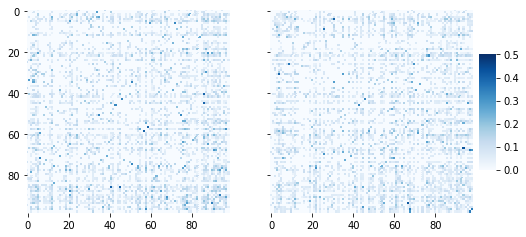

In [74]:
# plt.subplot(1,2,1)
# plt.imshow(dist_mtx, cmap='Blues',)
# plt.subplot(1,2,2)
# plt.imshow(shortest_dist_mtx, cmap='Blues',)
import seaborn as sns
import matplotlib.pyplot as plt

fig,axn = plt.subplots(1,2, sharex=False, sharey=True, figsize=(8,4))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
x_ticks = range(0,99,20)
y_ticks = range(0,99,20)
print(x_ticks)
sns.heatmap(dist_mtx, ax=axn.flat[0],
           cbar=False,square=True,cmap='Blues',vmin=0,vmax=0.50,xticklabels=20)
sns.heatmap(shortest_dist_mtx, ax=axn.flat[1],cbar=True,cbar_ax=cbar_ax,square=True,cmap='Blues',vmin=0,vmax=0.50,xticklabels=20,
            yticklabels=20
           )

plt.show()

fig.savefig('heatmap.png')

In [77]:
dist_diff = dist_mtx - shortest_dist_mtx
dist_diff_df = pd.DataFrame(dist_diff, columns = target_list_unique, index = target_list_unique)
dist_diff_df.to_csv(results_folder+'pathway_similarity_difference.csv')

In [34]:
np.mean(dist_diff)

0.0006523672467087839

In [104]:
dataset['score'] = cum_score_with_penalty
subset_selected = dataset.iloc[selected_path_list]
subset_shortest = dataset.iloc[shortest_path_list]
mean_sc_shortest = np.mean(subset_shortest['score'])
mean_sc_selected = np.mean(subset_selected['score'])
print(mean_sc_shortest, mean_sc_selected)

(0.6626733726419964, 0.6605364523728416)
